<a href="https://colab.research.google.com/github/YazeedMusallam/Riyadh-food-reviews-classification-using-machine-learning/blob/main/Food_reviews_google_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

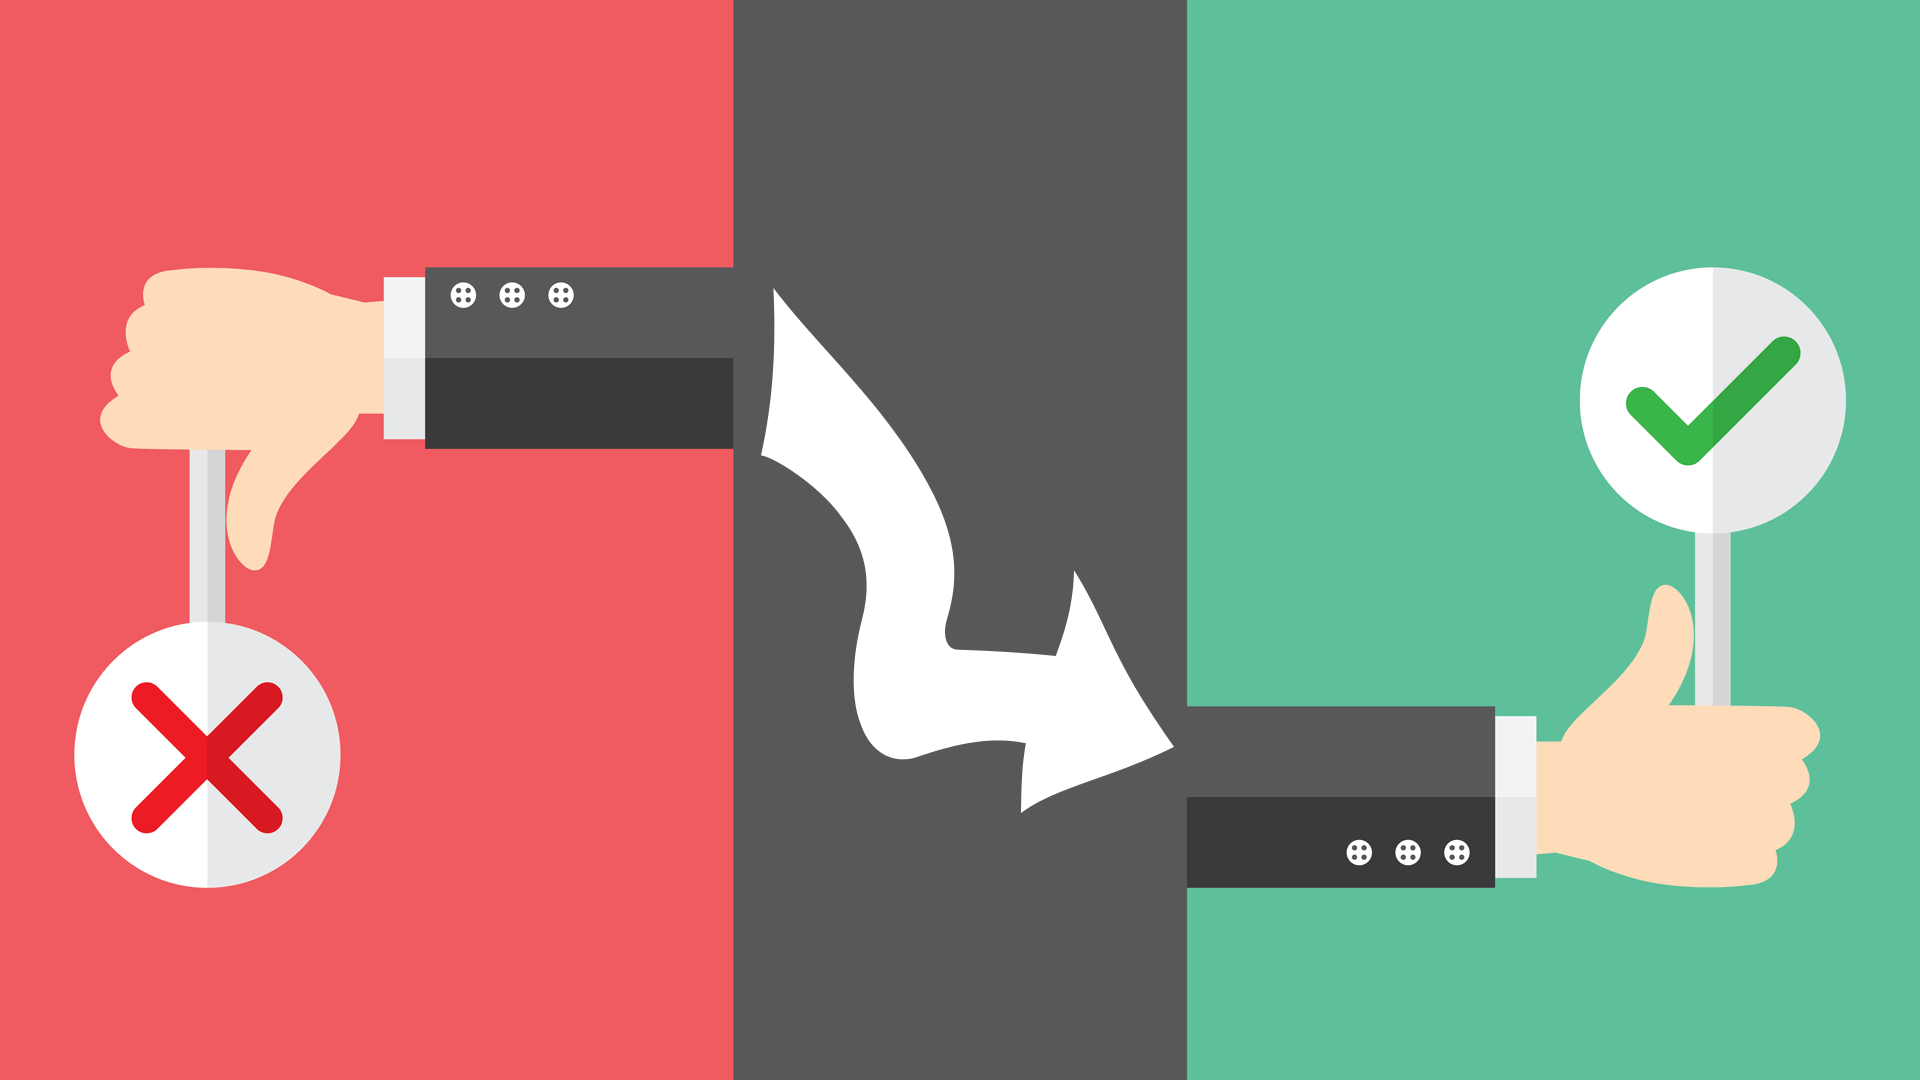

# Description of work

Overview:

> The goal of this project is to, build a robust user reviews classifcation model.



Problem statement:

> User reviews are important for restaurants owners, hence classfying a positive or negative review is an essential task for restaurant owners. Classifing i.e. twitter post by human is time consuming, hence creating an automated ML model to classify positive or negative posts for restaurant enhancement is important.



Scope of work:

> The goal of this project is to, build a robust user reviews classifcation model.



Datasets: 

>The first dataset contains food reviews which are scrapped from google maps: https://maps.google.com/maps

>The second dataset contains amazon food reviews reviews collected from Kaggle: https://www.kaggle.com/snap/amazon-fine-food-reviews 

# Imports

Mounting google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip install --upgrade --force-reinstall `cat /content/gdrive/My\ Drive/colab_installed.txt`

Mounted at /content/gdrive
ERROR: Invalid requirement: '@'


Installing essential libraries

In [2]:
!pip uninstall googletrans
!pip install googletrans==4.0.0-rc1
!pip install fake_useragent
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

     |████████████████████████████████| 55 kB 3.2 MB/s 
     |████████████████████████████████| 1.2 MB 20.4 MB/s 
     |████████████████████████████████| 42 kB 1.6 MB/s 
     |████████████████████████████████| 53 kB 2.5 MB/s 
     |████████████████████████████████| 65 kB 4.6 MB/s 
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17415 sha256=60c194016acfdb7a6992336449865a38866a09d4a15635f2fbe17411dd61738d
  Stored in directory: /root/.cache/pip/wheels/43/34/00/4fe71786ea6d12314b29037620c36d857e5d104ac2748bf82a
Successfully built googletrans
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=32ab468eba8c92715324421a0dec4bfa29814ba522db3679002244f2b844f812
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
Successfully built fake-useragent
     |████████████████████████████████| 904 kB 10.2 MB/s 
Get:1 https://cloud.r-project.org/bin/linux/ubuntu 

Importing libraries

In [3]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
import os
import time
from bs4 import BeautifulSoup
import math
import pandas as pd
from sqlalchemy import create_engine
from termcolor import colored, cprint
import re
from googletrans import Translator
import requests
from fake_useragent import UserAgent
from matplotlib import pyplot as plt
import sqlite3
import seaborn as sns
import string
import numpy as np 
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from googletrans import Translator
translator = Translator(service_urls=[
      'translate.google.com.sa',
    ])
chromedriver = "/Applications/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver

# Prep for web scraping

In [ ]:
def init():
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    options = Options()
    options.add_argument("--disable-notifications")
    options.add_argument("--lang=en")
    ua = UserAgent()
    a = ua.random
    user_agent = ua.random
    options.add_argument(f'user-agent={user_agent}')
    # chromedriver = "/Applications/chromedriver" # path to the chromedriver executable
    os.environ["webdriver.chrome.driver"] = chromedriver
    driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
    return driver

In [ ]:
def get_reviews(url):
    time.sleep(1)
    if ('=en' in url):
        driver.get(url)
    else:    
        driver.get(url+'?hl=en')
    while( driver.execute_script('return document.readyState') != 'complete'):
        pass
    driver.maximize_window()

    xpath = "//body/div[@id='app-container']/div[@id='content-container']/div[@id='pane']/div[1]/div[1]/div[1]/div[1]/div[2]/div[1]/div[1]/div[2]/div[1]/div[1]/span[1]/span[1]/span[1]/span[2]/span[1]/button[1]"
    try:
        WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, xpath)))
    except:
        return -1
    
    response = BeautifulSoup(driver.page_source, 'html.parser')
    NumofReviews = response.find_all('button', jsaction="pane.rating.moreReviews")[0]['aria-label'][:-8]
    NumofReviews = NumofReviews.replace(',','')
    print('This restaurant has: ',NumofReviews ,' reviews')
    driver.find_elements_by_xpath(xpath)[0].click()
    time.sleep(2)
    
    AreWeBlocked = 0
    
    if(NumofReviews == ''):
        NumofReviews = 0
    else:
        NumofReviews = int(NumofReviews)

    
    for number in range(math.ceil(NumofReviews/4+11)):
        AreWestuck = 0
        
        scrollable_div = driver.find_element_by_css_selector('div.section-scrollbox')
        driver.execute_script('arguments[0].scrollTop = arguments[0].scrollHeight', scrollable_div)
        Scroll = (driver.execute_script("return arguments[0].scrollHeight - arguments[0].scrollTop === arguments[0].clientHeight", scrollable_div))
        if(Scroll == False):
            AreWeBlocked = 0
        if(AreWeBlocked > 500):
            break
        while(driver.execute_script("return arguments[0].scrollHeight - arguments[0].scrollTop === arguments[0].clientHeight", scrollable_div)):
            time.sleep(0.10)
            AreWeBlocked = AreWeBlocked + 1
            AreWestuck = AreWestuck + 1
            if(AreWestuck > 10):
                break
            pass
    time.sleep(2)
    links = driver.find_elements_by_xpath("//button[contains(text(),'More')]")
    for l in links:
                l.click()
    time.sleep(2)

    response = BeautifulSoup(driver.page_source, 'html.parser')
    textlist = []
    
    count = 1
    for i in response.find_all('div', class_='ODSEW-ShBeI NIyLF-haAclf gm2-body-2'):
                # if( count % 10 == 0 ):
                #   print('Review number: ',count)
                count = count + 1
                text = i.find('span', class_='ODSEW-ShBeI-text').text
                if text  == '':
                    continue
                text = text.replace('\r', ' ').replace('\n', ' ').replace('\t', ' ')
                if('Translated by Google' in text):
                    text = text.split('(Original)')[0].split('(Translated by Google)')[1].strip()
                emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
                text = emoji_pattern.sub(r'', text).replace("  ", " ")
                try:
                    rate = i.find('span', class_='ODSEW-ShBeI-H1e3jb')['aria-label'][1]
                    date = i.find('span', class_='ODSEW-ShBeI-RgZmSc-date').text
                except:
                    continue
                if (rate  == '' and date  == ''):
                    continue
                if(not text.isascii()):
                    try:
                        translator = Translator()
                        text = translator.translate(text, dest='en').text
                    except:
                        text = text + "(TRANSLATE)"
                        textlist.append([text, rate, date])
                        print("Error occurd")
                        continue
                textlist.append([text, rate, date])
    df_new = pd.DataFrame(textlist,columns =['Review', 'Rate', 'Date'])    
    return df_new

## Get restaurants names

In [ ]:
driver = init()

url = "https://www.google.com/maps/search/restaurants/@24.7953375,46.6750893,14z/data=!3m1!4b1!4m2!2m1!6e5"
if ('=en' in url):
    driver.get(url)
else:    
    driver.get(url+'?hl=en')
while( driver.execute_script('return document.readyState') != 'complete'):
    pass
driver.maximize_window()

In [ ]:
restaurants = dict()

In [ ]:
response = BeautifulSoup(driver.page_source, 'html.parser')
links = response.find_all('a', class_='a4gq8e-aVTXAb-haAclf-jRmmHf-hSRGPd')
for i in range(len(links)):
    restaurants[str(links[i]['aria-label'])] = links[i]['href']

WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, "//button[@aria-label=' Next page ']"))).click()

In [ ]:
len(restaurants.values())

In [ ]:
for i in restaurants.values():
    print(i)

save resturent link

In [ ]:
import pickle

In [ ]:
with open('restaurants.pickle', 'wb') as handle:
    pickle.dump(restaurants, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Web scrapping

In [ ]:
con = sqlite3.connect("/content/gdrive/MyDrive/RES.db")

In [ ]:
res = pd.read_sql_query("SELECT * FROM url", con)

In [ ]:
#Number of restaurants
len(res)

333

In [ ]:
#Create data frame to be scrapped
df = pd.DataFrame({"Review":[], "Rate":[], 'Date':[], 'Restaurant': []})

In [ ]:
#Scrapping method
driver = init()
ResCount = 1

for i in range(len(res)):
                if(ResCount < 283):
                    ResCount = ResCount + 1
                    continue
                    
                # if(ResCount >= 170):
                #     break
                name, url = res.iloc[i,0], res.iloc[i,1]
                print('Restaurant number: ', ResCount, 'out of ', len(res))
                textlist = get_reviews(url)
                if(type(textlist) != pd.core.frame.DataFrame):
                    ResCount = ResCount + 1
                    continue
       
                textlist = textlist.join(pd.DataFrame({'Restaurant': [name]*len(textlist)}),how='outer')
                cprint(str('We got : ' + str(len(textlist)) +' reviews'), 'green')
                textlist = textlist.reset_index(drop='index')
                df = pd.concat([df, textlist])
                ResCount = ResCount + 1
                time.sleep(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: use options instead of chrome_options
  from ipykernel import kernelapp as app


Restaurant number:  283 out of  333
This restaurant has:  3290  reviews
We got : 930 reviews
Restaurant number:  284 out of  333
This restaurant has:  1058  reviews
We got : 620 reviews
Restaurant number:  285 out of  333
This restaurant has:  13  reviews
We got : 6 reviews
Restaurant number:  286 out of  333
This restaurant has:  4  reviews
We got : 3 reviews
Restaurant number:  287 out of  333
This restaurant has:  23  reviews
We got : 6 reviews
Restaurant number:  288 out of  333
This restaurant has:    reviews
We got : 1 reviews
Restaurant number:  289 out of  333
This restaurant has:  875  reviews
We got : 492 reviews
Restaurant number:  290 out of  333
This restaurant has:  209  reviews
We got : 112 reviews
Restaurant number:  291 out of  333
This restaurant has:  27  reviews
We got : 11 reviews
Restaurant number:  292 out of  333
This restaurant has:  935  reviews
We got : 413 reviews
Restaurant number:  293 out of  333
This restaurant has:  59  reviews
We got : 44 reviews
Resta

In [ ]:
df = df.reset_index(drop='index')
df

,Review,Rate,Date,Restaurant
0,One of the best and my favorite buffet in Riya...,5,3 months ago,The 365
1,The best Sushi in Riyadh!! Gorgeous hotel with...,5,2 years ago,The 365
2,Athentic Foods is here only at Hotel Fairmont ...,5,a year ago,The 365
3,Great food one of the top 10 in riyadh,5,3 months ago,The 365
4,"The place is amazing, and all the staff are fr...",5,a year ago,The 365
...,...,...,...,...
110063,Wonderful,5,3 years ago,مطاعم هاشم - Wadi Laban
110064,good,4,4 years ago,مطاعم هاشم - Wadi Laban
110065,clean and tidy,5,4 years ago,مطاعم هاشم - Wadi Laban
110066,Aaa,3,2 years ago,مطاعم هاشم - Wadi Laban


## saving to pickle

In [ ]:
!ls

GoogleReviews.db     __pycache__          monitor.py
GoogleReviews1.db    data                 py-googletrans
LICENSE              gm-scraper.log       requirements.txt
Project.ipynb        googlemaps.py        restaurants.pickle
README.md            googlemaps.py.save   scraper.py
Untitled.ipynb       googlemaps.py.save.1 urls.txt
Untitled1.ipynb      googlemaps.py.save.2


In [ ]:
import pickle

with open('/content/gdrive/MyDrive/new_df.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

# EDA

## 1. Importing the dataset from pikkle

In [4]:
df = pd.read_pickle("/content/gdrive/MyDrive/new_df2.pickle")

In [5]:
# #!pip install deep-translator
# from deep_translator import GoogleTranslator, PonsTranslator, LingueeTranslator

In [6]:
# # translator = Translator()
# df = df.Review.apply(lambda text: GoogleTranslator(source='auto', target='en').translate(text=text) if not text.isascii() else text)

In [7]:
df.head()

,Review,Rate,Date,Restaurant
0,One of the best and my favorite buffet in Riya...,5,3 months ago,The 365
1,The best Sushi in Riyadh!! Gorgeous hotel with...,5,2 years ago,The 365
2,Athentic Foods is here only at Hotel Fairmont ...,5,a year ago,The 365
3,Great food one of the top 10 in riyadh,5,3 months ago,The 365
4,"The place is amazing, and all the staff are fr...",5,a year ago,The 365


In [8]:
#What are the top restaurant
df[df.Rate=='5'].groupby('Restaurant')['Rate'].count().sort_values(ascending=False).head(15)

Restaurant
Welcome Indian Restaurant                              1378
TERRACE N09                                             811
Harat Restaurant                                        777
Mizo Eatery                                             761
Zafran                                                  753
Zafran Indian Bistro                                    750
Awani                                                   747
Zaatar W Zeit - Tahliah                                 721
Annabella Ristorante Italiano مطعم أنابيلا الإيطالي     710
Panda Express                                           698
FARZI CAFE                                              666
The Butcher Shop & Grill                                612
Nakheel Mall                                            607
offwhite lounge Al-Nafl - أوف وايت النفل                596
Wildfire Brazilian Steakhouse - وايلد فاير              595
Name: Rate, dtype: int64

## 1. Basic information about dataset and clean the data

Here we  look at basic information about the dataset

In [9]:
# Dataframe dimensions
df.shape

(110068, 4)

In [10]:
# Display first 10 rows
df.head(10)

,Review,Rate,Date,Restaurant
0,One of the best and my favorite buffet in Riya...,5,3 months ago,The 365
1,The best Sushi in Riyadh!! Gorgeous hotel with...,5,2 years ago,The 365
2,Athentic Foods is here only at Hotel Fairmont ...,5,a year ago,The 365
3,Great food one of the top 10 in riyadh,5,3 months ago,The 365
4,"The place is amazing, and all the staff are fr...",5,a year ago,The 365
5,"Very unique, fresh delicious food, suitable fo...",5,a year ago,The 365
6,"One of the best restaurants ,especially in Riy...",5,a year ago,The 365
7,Great place for lunch. The service is brilliant,4,a year ago,The 365
8,"Excellent food, great choice across good stations",5,a year ago,The 365
9,"I liked this restaurant, the service, the qual...",5,2 years ago,The 365


In [11]:
# Column datatypes
df.dtypes

Review        object
Rate          object
Date          object
Restaurant    object
dtype: object

In [12]:
#Change rate type to int
df.Rate = df.Rate.astype(int)
df.dtypes

Review        object
Rate           int64
Date          object
Restaurant    object
dtype: object

In [13]:
df.describe()

,Rate
count,110068.000000
mean,4.061135
std,1.274551
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


## Checking and cleaning the data

## Summary of data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


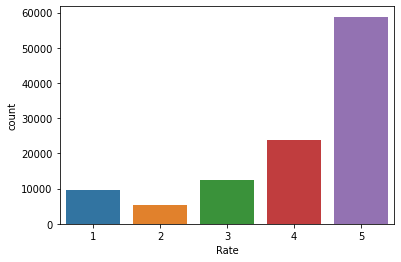

In [14]:
#Show distribution of scores
sns.countplot(df['Rate'])
plt.show()

In [15]:
# Display unique values of 'Restaurant'
nh = df['Restaurant'].unique()
nh

array(['The 365', 'ULounge Restaurant -مطعم يولاونج',
       'delice & lounge restaurant', 'Harat Restaurant', 'Benihana',
       'City Fresh Kitchen', 'TERRACE N09', 'Acme restaurant', "Hardee's",
       'offwhite lounge Al-Nafl - أوف وايت النفل', 'Mizo Eatery',
       'Fuddruckers', 'The Spot Restaurant', 'Piatto Restaurant',
       'Margherita', 'Bistro Chino',
       "سيسيليز بيتزا كتس - Sicilia's Pizza Cuts",
       'Paul Bakery & Restaurant', 'Johnny Rockets',
       'Zafran Indian Bistro - Levels Mall', 'Lotus', 'Kosebasi',
       'Pakistani Restaurant',
       "مطعم ملعقة الطاهي - Chef's Spoon Restaurant",
       'Golden salamon restaurant', 'Steak House',
       'Annabella Ristorante Italiano مطعم أنابيلا الإيطالي', 'SHRIMPER',
       'Juice Star Turkish', 'Sham Square Restaurant',
       'Nando’s Granada Mall', "Nando's Levels Mall", 'Oregano Pizzeria',
       'Lean Meals', 'Fish pan', 'Alfa Co. For Operation Services Ltd.',
       'Rahat Hotel (Kerala Restaurant)', 'One Poun

In [16]:
#Number of restaurants?
len(nh)

275

In [17]:
df.head()

,Review,Rate,Date,Restaurant
0,One of the best and my favorite buffet in Riya...,5,3 months ago,The 365
1,The best Sushi in Riyadh!! Gorgeous hotel with...,5,2 years ago,The 365
2,Athentic Foods is here only at Hotel Fairmont ...,5,a year ago,The 365
3,Great food one of the top 10 in riyadh,5,3 months ago,The 365
4,"The place is amazing, and all the staff are fr...",5,a year ago,The 365


In [18]:
# Summarize categorical features
df.describe(include=['object'])

,Review,Date,Restaurant
count,110068,110068,110068
unique,92458,53,275
top,Good,a year ago,Welcome Indian Restaurant
freq,1481,24104,2455


In [19]:
#Checking if there is null
df.isnull().sum()

Review        0
Rate          0
Date          0
Restaurant    0
dtype: int64

In [20]:
#Checking if there is duplicate
print(df.duplicated().sum())

5617


In [21]:
#Show me the duplicate
df[df.duplicated(keep=False)].head(20)

,Review,Rate,Date,Restaurant
378,delicious food,5,2 years ago,ULounge Restaurant -مطعم يولاونج
379,delicious food,5,2 years ago,ULounge Restaurant -مطعم يولاونج
449,,4,a year ago,delice & lounge restaurant
641,,4,a year ago,delice & lounge restaurant
1374,"Food, staff and hospitality are outstanding th...",5,a year ago,Harat Restaurant
1376,All the food we ordered today was very good! S...,5,a year ago,Harat Restaurant
1385,All the food we ordered today was very good! S...,5,a year ago,Harat Restaurant
1397,All the food we ordered today was very good! S...,5,a year ago,Harat Restaurant
1460,"Food, staff and hospitality are outstanding th...",5,a year ago,Harat Restaurant
1507,It’s one of the best. The service are really t...,5,a year ago,Harat Restaurant


In [22]:
 #drop duplicates
 df.drop_duplicates(inplace=True)

In [23]:
#Deconcatenation (i.e won't ==> will not)
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
df.Review = df.Review.apply(decontracted)

#Removing numbers
def rem_num(phrase):
  return re.sub("\S*\d\S*", "", phrase).strip().replace('  ', ' ')
df.Review = df.Review.apply(rem_num)

#Removing spacial character
def rem_char(phrase):
  return re.sub('[^A-Za-z]+', ' ', phrase).strip().replace('  ', ' ')
df.Review = df.Review.apply(rem_char)

#Removing html tags
def rem_html(phrase):
  return re.sub('[^A-Za-z]+', ' ', phrase)
df.Review = df.Review.apply(rem_html)

df.head()

,Review,Rate,Date,Restaurant
0,One of the best and my favorite buffet in Riya...,5,3 months ago,The 365
1,The best Sushi in Riyadh Gorgeous hotel with a...,5,2 years ago,The 365
2,Athentic Foods is here only at Hotel Fairmont ...,5,a year ago,The 365
3,Great food one of the top in riyadh,5,3 months ago,The 365
4,The place is amazing and all the staff are fri...,5,a year ago,The 365


In [24]:
#removing stop words
stopwords= set([
    'br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're",
    "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his',
    'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they',
    'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that',
    "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have',
    'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
    'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against',
    'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from',
    'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
    'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
    'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't',
    'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're',
    've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't",
    'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn',
    "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't",
    'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
    ])
def rem_stopwords(phrase):
  return ' '.join(e.lower() for e in phrase.split() if e.lower() not in stopwords)
df.Review = df.Review.apply(rem_stopwords)

In [25]:
df.head()

,Review,Rate,Date,Restaurant
0,one best favorite buffet riyadh missing much s...,5,3 months ago,The 365
1,best sushi riyadh gorgeous hotel amazing resta...,5,2 years ago,The 365
2,athentic foods hotel fairmont riyadh come expe...,5,a year ago,The 365
3,great food one top riyadh,5,3 months ago,The 365
4,place amazing staff friendly big thanks amazin...,5,a year ago,The 365


## Preparing for sentiment anaylsis

In [26]:
# Only these two columns are needed for classifcation
df_new = df.loc[:, ['Review', 'Rate','Restaurant']]

In [27]:
# Add score col.
def get_score(value):
    if int(value) > 3:
        return 1
    else:
        return 0
df_new['Score'] = df_new['Rate'].apply(get_score)

In [28]:
#Drop rate col.
df_new.drop(columns="Rate", inplace=True)

In [29]:
#Exclude empty reviews
df_new = df_new[df_new.Review != '']

In [30]:
#Describe the score
df_new.describe()

,Score
count,103783.000000
mean,0.748832
std,0.433687
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [31]:
df_new.head()

,Review,Restaurant,Score
0,one best favorite buffet riyadh missing much s...,The 365,1
1,best sushi riyadh gorgeous hotel amazing resta...,The 365,1
2,athentic foods hotel fairmont riyadh come expe...,The 365,1
3,great food one top riyadh,The 365,1
4,place amazing staff friendly big thanks amazin...,The 365,1


In [32]:
df_new = pd.read_pickle("/content/gdrive/MyDrive/new_df3.pickle")

## Vizualizing the data

1    80343
0    27136
Name: Score, dtype: int64


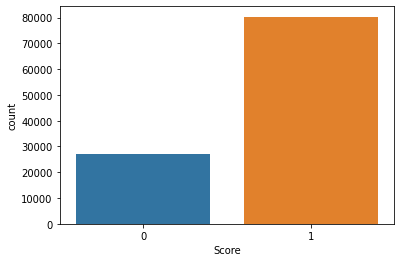

In [33]:
print(df_new['Score'].value_counts())
sns.countplot(x='Score', data=df_new)
plt.show()

## Dealing with class imbalance (undersampling)

In [34]:
#Shuffle the data
df_new = df_new.sample(frac=1).reset_index(drop=True)
df_new.head()

,Review,Restaurant,Score
0,"The worst service in riyadh, i like the food a...",Zaatar W Zeit - Tahliah,0
1,Quiet environment on weekend mornings. I love it,Fuddruckers,1
2,An indian restaurant serving breakfast and lunch,Shalimar Restaurant,0
3,Good,Sagar Indian Fast Food,1
4,The food was delicious with great service espe...,FARZI CAFE,1


The below cells was tested to balance the two sets.
Results: bad classification accuracy 

In [35]:
# Neg reviews = postive reviews
df_new[df_new['Score'] == 1] = df_new[df_new['Score'] == 1].iloc[:len(df_new[df_new['Score'] == 0]),:]

In [36]:
# drop null rows
df_new.dropna(inplace=True)

1.0    27136
0.0    27136
Name: Score, dtype: int64


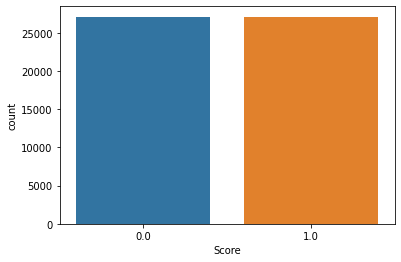

In [37]:
# recheck for imbalance
print(df_new['Score'].value_counts())
sns.countplot(x='Score', data=df_new)
plt.show()

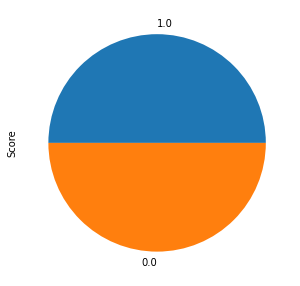

In [38]:
#Pie chart
df_new['Score'].value_counts().plot.pie(figsize=(5, 5))
plt.show()

# Feature Engineering and data visualization

In [39]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54272 entries, 0 to 107471
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Review      54272 non-null  object 
 1   Restaurant  54272 non-null  object 
 2   Score       54272 non-null  float64
dtypes: float64(1), object(2)
memory usage: 4.2+ MB


## Spliting before to prevent any data leakage

In [40]:
import random
res_list = list(df_new.Restaurant.unique())
random.shuffle(res_list)
del res_list[0:54]

In [41]:
#Split
X_train = df_new[df_new.Restaurant.isin(res_list)].Review
X_test = df_new[~df_new.Restaurant.isin(res_list)].Review

y_train = df_new[df_new.Restaurant.isin(res_list)].Score
y_test = df_new[~df_new.Restaurant.isin(res_list)].Score

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1) # 0.25 x 0.8 = 0.2

In [43]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34383,)
(11293,)
(8596,)


In [44]:
X_train.head()

10052                                            Overrated
17836        Very tasty but the service staff needs alerts
26736    Excellent food ..very good service...mr Amro v...
14766    The food is very tasty, like the risotto with ...
27820    A restaurant specializing in Kuwaiti food The ...
Name: Review, dtype: object

In [45]:
X_train = pd.DataFrame(X_train.reset_index().drop(columns='index'))
X_test = pd.DataFrame(X_test.reset_index().drop(columns='index'))
X_val = pd.DataFrame(X_val.reset_index().drop(columns='index'))

y_train = pd.DataFrame(y_train.reset_index().drop(columns='index'))
y_test = pd.DataFrame(y_test.reset_index().drop(columns='index'))
y_val = pd.DataFrame(y_val.reset_index().drop(columns='index'))

In [46]:
def feature_engineering(data):
  ## Number of words in the text
  data["num_words"] = data["Review"].apply(lambda x: len((x).split()))

  ## Number of unique words in the text
  data["num_unique_words"] = data["Review"].apply(lambda x: len(set((x).split())))

  ## Number of characters in the text 
  data["num_chars"] = data["Review"].apply(lambda x: len((x)))

  ## Number of stopwords in the text
  data["num_stopwords"] = data["Review"].apply(lambda x: len([w for w in (x).lower().split() if w in STOPWORDS]))

  ## Number of punctuations in the text 
  data["num_punctuations"] = data['Review'].apply(lambda x: len([c for c in (x) if c in string.punctuation]) )

  ## Average length of the words in the text 
  data["mean_word_len"] = data["Review"].apply(lambda x: np.mean([len(w) for w in (x).split()]))
  return data
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)
X_val = feature_engineering(X_val)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Keeping the useful rows

In [47]:
def use_parm(data,label):
   ind = data[(data.num_words > 5) &(data.num_words <= 100) & (data.num_punctuations <= 15) & (data.mean_word_len <= 7) & (data.num_chars<210)].index
   data = data[data.index.isin(ind)]
   label = label[label.index.isin(ind)]
   return data, label
X_train, y_train = use_parm(X_train, y_train)
# X_test, y_test = use_parm(X_test, y_test)
# X_val, y_val = use_parm(X_val, y_val)

In [48]:
#removing 'Name' in string
def rem_name(data,label):
   ind = (data[(~data.Review.str.contains('Name', regex=False)) & (~data.Review.str.contains('name', regex=False))]).index
   data = data[data.index.isin(ind)]
   label = label[label.index.isin(ind)]
   return data, label
X_train, y_train = rem_name(X_train, y_train)
X_test, y_test = rem_name(X_test, y_test)
X_val, y_val = rem_name(X_val, y_val)

In [49]:
(X_train[X_train.Review.str.contains('name', regex=False)])

,Review,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,mean_word_len


In [50]:
X_train.head()

,Review,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,mean_word_len
1,Very tasty but the service staff needs alerts,8,8,45,3,0,4.750000
2,Excellent food ..very good service...mr Amro v...,13,13,83,4,7,5.461538
4,A restaurant specializing in Kuwaiti food The ...,30,25,155,13,2,4.200000
5,The taste of eating is normal and the prices a...,13,13,65,6,2,4.076923
7,The place has an excellent view. The reception...,25,21,144,12,4,4.800000


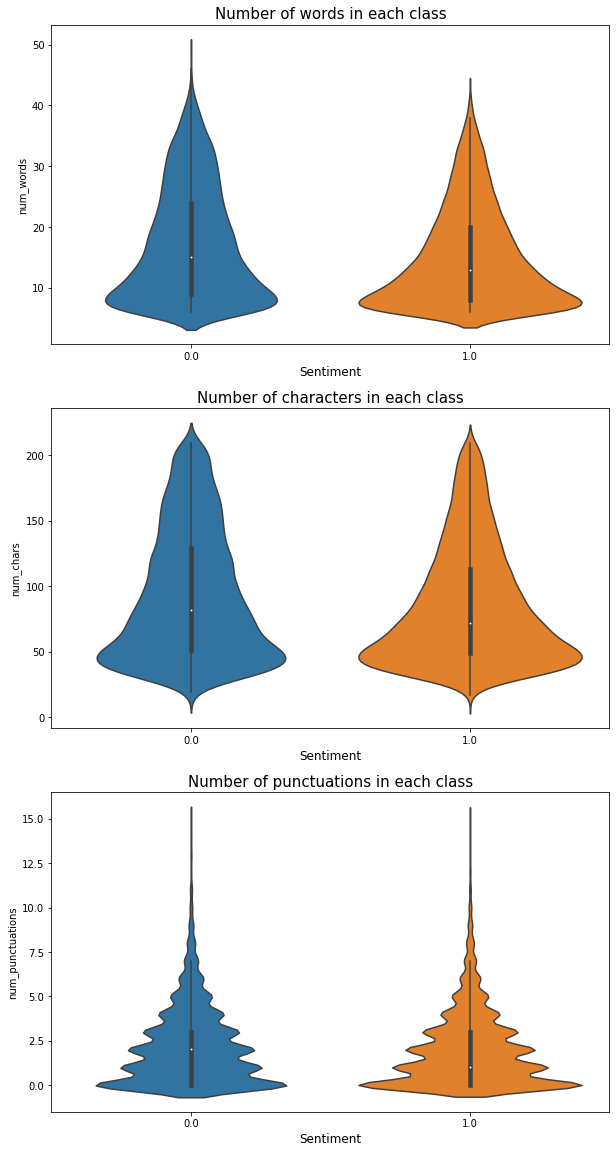

In [51]:
# Violin plot of each feature
f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.violinplot(x=y_train.Score, y='num_words', data=X_train, ax=axes[0])
axes[0].set_xlabel('Sentiment', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.violinplot(x=y_train.Score, y='num_chars', data=X_train, ax=axes[1])
axes[1].set_xlabel('Sentiment', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.violinplot(x=y_train.Score, y='num_punctuations', data=X_train, ax=axes[2])
axes[2].set_xlabel('Sentiment', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


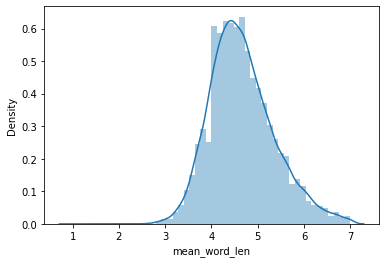

<Figure size 720x1440 with 0 Axes>

In [52]:
#Distrubtion of mean word length
sns.distplot(X_train['mean_word_len'])
plt.figure(figsize=(10,20))
plt.show()

# Amazon food reviews dataset (merging to our dataset)

In [53]:
X_train = X_train.Review
X_test = X_test.Review
X_val = X_val.Review

In [54]:
data = pd.read_csv('/content/gdrive/MyDrive/Reviews.csv') #Read from CSV

In [55]:
#Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)
data.rename(columns={"Text":"Review"}, inplace=True)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Review
0,311253,B001EQ4NWK,AROE18LXUMV20,"Stephen Wimmer ""Stephenish""",14,14,5,1331164800,"Lightly salted, American product",These hulled sunflower seeds are lightly salte...
1,35339,B000GW46D4,A2ZSK8NC6PX0ZY,"Donald G. Dassel ""Donald347""",3,3,5,1260057600,Excellent Protein Quatity,I find the Jack Links Teriyaki Beef Steaks exc...
2,160666,B001BOQ3SW,A10Q1QIHVXKT8M,"Teresa Walker ""doggie mom""",29,29,5,1148515200,Wellness for well fed doggies,"I have two large dogs, one a yellow lab, and t..."
3,523508,B00511MLLO,A3K8G6TK9BH37T,K & T,3,3,5,1341273600,"Great, caffeine-free tea",I'm not generally a fan of herbal teas -- most...
4,257098,B000EUF9D4,AU6890Q08RKEG,V. T.,0,2,1,1271030400,Milk chocolate with cherries,The chocolate is not smooth and left a strange...


In [56]:
#keep only 100k
data = data.iloc[:100000,:]

In [57]:
#lets remove the duplicates
data.drop_duplicates(inplace=True)
print(data.duplicated().sum())

# drop null rows
data.dropna(inplace=True)

#Exclude empty reviews
data = data[data.Review != '']

0


In [58]:
# Neg reviews = postive reviews
data.Score = data.Score.apply(get_score)
data[data['Score'] == 1] = data[data['Score'] == 1].iloc[:len(data[data['Score'] == 0]),:]

In [59]:
# drop null rows
data.dropna(inplace=True)

In [60]:
col = ['Review',
       'num_words', 'num_unique_words', 'num_chars', 'num_stopwords',
       'num_punctuations', 'mean_word_len']

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43738 entries, 0 to 99997
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      43738 non-null  float64
 1   ProductId               43738 non-null  object 
 2   UserId                  43738 non-null  object 
 3   ProfileName             43738 non-null  object 
 4   HelpfulnessNumerator    43738 non-null  float64
 5   HelpfulnessDenominator  43738 non-null  float64
 6   Score                   43738 non-null  float64
 7   Time                    43738 non-null  float64
 8   Summary                 43738 non-null  object 
 9   Review                  43738 non-null  object 
dtypes: float64(5), object(5)
memory usage: 3.7+ MB


In [62]:
def use_parm_2(data,label):
   ind = data[(data.num_words <= 100) & (data.num_punctuations <= 15) & (data.mean_word_len <= 7) & (data.num_chars<210)].index
   data = data[data.index.isin(ind)]
   label = label[label.index.isin(ind)]
   return data, label

In [63]:
data = feature_engineering(data)
label_ho = data.Score
data_ho = data.loc[:,col]
data_ho, label_ho = use_parm_2(data_ho, label_ho)
data_ho, label_ho = rem_name(data_ho, label_ho)
data_ho = data_ho.Review
data_ho = data_ho.apply(decontracted).apply(rem_num).apply(rem_stopwords).apply(rem_html)

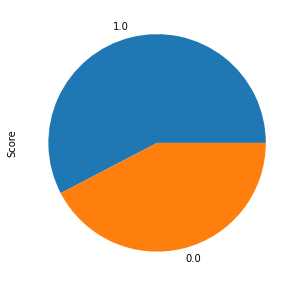

1.0    7470
0.0    5488
Name: Score, dtype: int64

In [64]:
#Pie chart
label_ho.value_counts().plot.pie(figsize=(5, 5))
plt.show()
label_ho.value_counts()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


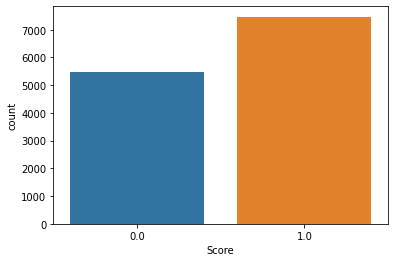

In [65]:
# recheck for imbalance
sns.countplot(label_ho)
plt.show()

In [66]:
data_ho = pd.DataFrame(data_ho.reset_index().drop(columns='index'))
label_ho = pd.DataFrame(label_ho.reset_index().drop(columns='index'))
data_ho = data_ho.Review

In [67]:
X_train = pd.concat([X_train, data_ho])
y_train = pd.concat([y_train, label_ho])

In [68]:
idx = X_train.drop_duplicates().index
X_train = X_train[X_train.index.isin(idx)]
y_train = y_train[y_train.index.isin(idx)]

In [69]:
X_train = pd.DataFrame(X_train.reset_index().drop(columns='index'))
X_test = pd.DataFrame(X_test.reset_index().drop(columns='index'))
X_val = pd.DataFrame(X_val.reset_index().drop(columns='index'))

y_train = pd.DataFrame(y_train.reset_index().drop(columns='index'))
y_test = pd.DataFrame(y_test.reset_index().drop(columns='index'))
y_val = pd.DataFrame(y_val.reset_index().drop(columns='index'))

In [70]:
X_train = X_train.Review
X_test = X_test.Review
X_val = X_val.Review

y_train = y_train.Score
y_test = y_test.Score
y_val = y_val.Score

In [71]:
y_train.value_counts()

1.0    17565
0.0    15303
Name: Score, dtype: int64

# Word cloud

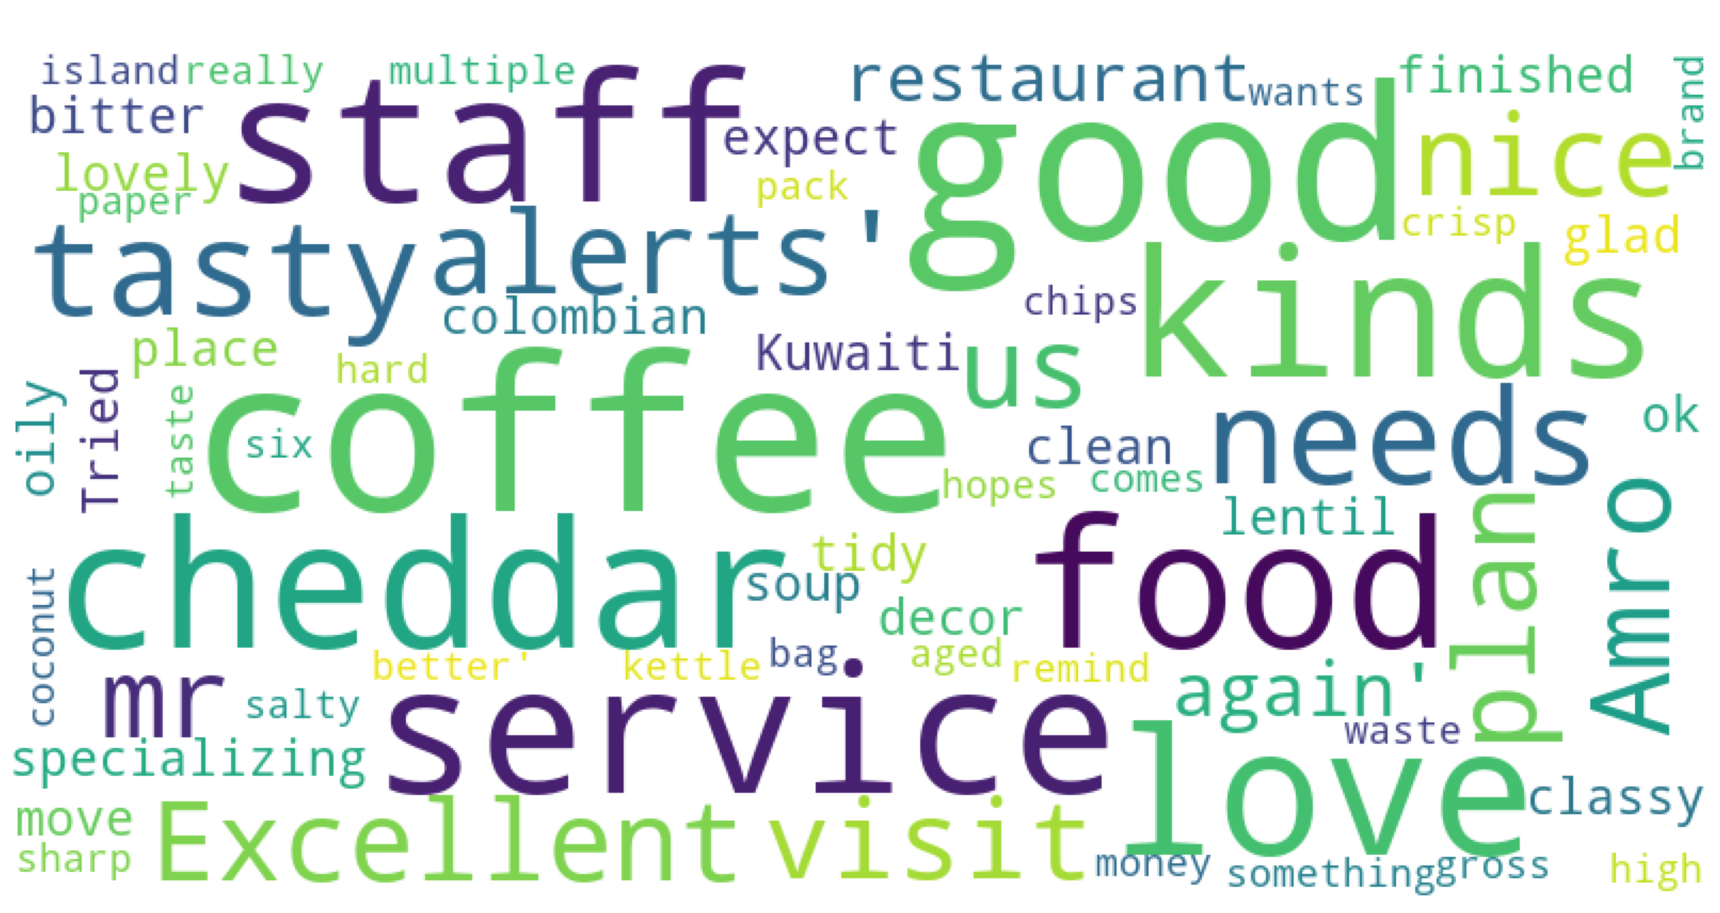

In [72]:
#word cloud for most frequent words
from wordcloud import WordCloud, ImageColorGenerator

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False, pn='p'):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'white', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    plt.savefig('/content/gdrive/MyDrive/Food/static/plot{}.png'.format(pn))
    plt.show()
    
plot_wordcloud(pd.DataFrame(X_train).values, title="Word Cloud of Google maps Reviews", pn='n')

# Model Building

Imports:

In [73]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,f1_score,accuracy_score,ConfusionMatrixDisplay,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


## Covert text to vectors (BoW)

In [74]:
#Convert text to Bag of words for each word.
bow = CountVectorizer()
bow_counts = bow.fit_transform(X_train.values)
bow_counts.shape

(32868, 18681)

In [75]:
#don't forgot to normalize train data
X_bow = normalize(bow_counts,axis=0)
#convert cv text to Bow vectors
X_val_bow = bow.transform(X_val.values)
#don't forgot to normalize cv data
X_val_bow = normalize(X_val_bow,axis=0)
#convert test text to Bow vectors
X_test_bow = bow.transform(X_test.values)
#don't forgot to normalize cv data
X_test_bow = normalize(X_test_bow,axis=0)

## Convert text to vectors (TD-IDF)

In [76]:
#Convert text to tfidf for each word in the corpus.
#We consider only uni-grams as computing time and space is less.
tfidf_vect = TfidfVectorizer(ngram_range=(1,1))
final_tfidf = tfidf_vect.fit_transform(X_train.values)

In [77]:
#print top 10 tfidf words.
#High tfidf value implies word is more important compared to less tfidf value word.
features = tfidf_vect.get_feature_names()
len(features)

# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=10):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tfidf[1,:].toarray()[0],features,10)
top_tfidf

,feature,tfidf
0,amro,0.525642
1,plan,0.389783
2,mr,0.308863
3,very,0.306686
4,us,0.277935
5,visit,0.256326
6,again,0.222188
7,excellent,0.193965
8,with,0.190054
9,nice,0.181808


In [78]:
#don't forgot to normalize train data
X_tfidf = normalize(final_tfidf,axis=0)
#convert cv text to tfidf vectors
X_val_tfidf = tfidf_vect.transform(X_val.values)
#don't forgot to normalize cv data
X_val_tfidf = normalize(X_val_tfidf,axis=0)
#convert test text to tfidf vectors
X_test_tfidf = tfidf_vect.transform(X_test.values)
#don't forgot to normalize cv data
X_test_tfidf = normalize(X_test_tfidf,axis=0)

In [79]:
#function to give various scores on test data for a given model.
def cal_metrics(predicted,actual):
  conf = confusion_matrix(predicted,actual)
  TN,FN,FP,TP = conf[0][0],conf[0][1],conf[1][0],conf[1][1]
  P = TP+FN
  N = TN+FP
  TPR = TP/P
  FPR = FP/P
  FNR = FN/N
  TNR = TN/N
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  f1_score =  2 * (precision * recall) / (precision + recall)
  acc = accuracy_score(predicted,actual)
  report=classification_report(predicted,actual)
  print(report)
  print('Various metrics of model:')
 
  print('Precision is:',precision*100)
  print('Recall is:',recall*100)
  
  print('F1 score is:',f1_score*100)
  print('Accuracy is:',acc*100,'\n')
  cf_matrix = confusion_matrix(predicted,actual, normalize='pred')
  # Generate confusion matrix plot
  display_labels = ['Negative', 'Postive']
  disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=display_labels)
  disp = disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')
  plt.grid(False)
  disp.ax_.set_xticklabels(display_labels, rotation=12)
  plt.title('Confusion Matrix of Google Maps Reviews')

  plt.show()

In [80]:
#function to print top 10 positive and negative features
def imp_features(vectorizer,clf):
  feature_names = vectorizer.get_feature_names()
  n = clf.coef_[0].shape[0]
  coefs_with_features = sorted(zip(clf.coef_[0], feature_names))
  positive = coefs_with_features[:n-11:-1]
  negative = coefs_with_features[:10]
  positive = [i[1] for i in positive]
  negative = [i[1] for i in negative]

  top = {'positive':positive,'negative':negative}
  print('Top positive and negative features/words')
  top = pd.DataFrame(data=top)
  return top

## Logistic regression (TD-IDF)

For C = 0.000010, val score is : 0.785371
For C = 0.000100, val score is : 0.787591
For C = 0.001000, val score is : 0.788678
For C = 0.010000, val score is : 0.789024
For C = 0.100000, val score is : 0.790994
For C = 1.000000, val score is : 0.796492
For C = 10.000000, val score is : 0.797802


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


For C = 100.000000, val score is : 0.780763


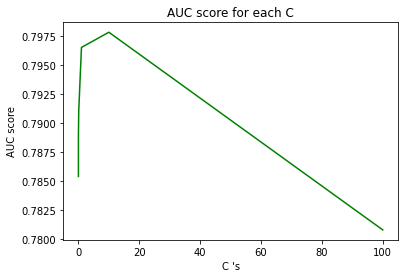


The optimal C is 10.000000.


In [ ]:
val_auc = []
Cs = [0.00001,0.0001,0.001,0.01,0.1,1,10,100]
for i in Cs:
    clf = LogisticRegression(C=i,class_weight='balanced')
    clf.fit(X_tfidf,np.array(y_train).reshape(-1,))
    y_pred_val = clf.predict(X_val_tfidf)
    score = roc_auc_score(y_val, y_pred_val)
    print('For C = %f, val score is : %f' %(i,score))
    val_auc.append(score)
    
#plot errors and val scores
fig, ax = plt.subplots()
ax.plot(Cs, val_auc,c='g')
plt.grid()
plt.title("AUC score for each C")
plt.xlabel("C 's")
plt.ylabel("AUC score")
plt.grid()
plt.show()

# determining best C
MSE = [x for x in val_auc]
# determining best C
optimal_c = Cs[MSE.index(max(MSE))]
print('\nThe optimal C is %f.' % optimal_c)

              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79      4714
         1.0       0.81      0.83      0.82      5292

    accuracy                           0.80     10006
   macro avg       0.80      0.80      0.80     10006
weighted avg       0.80      0.80      0.80     10006

Various metrics of model:
Precision is: 82.5774754346183
Recall is: 80.8660251665433
F1 score is: 81.71278982797307
Accuracy is: 80.45172896262243 



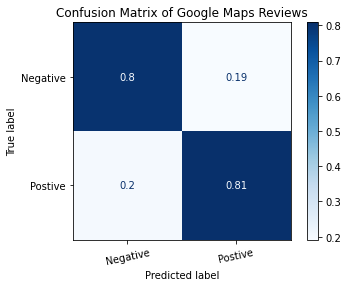

In [ ]:
#train model with C.
clf = LogisticRegression(C=optimal_c,class_weight='balanced')
clf.fit(X_tfidf,y_train)
#predict y labels with model on test data
predict = clf.predict(X_test_tfidf)
#Performance of the model on the test data
cal_metrics(predict,y_test)

In [ ]:
y_pred_train = clf.predict(X_tfidf)
y_pred_test = clf.predict(X_test_tfidf)
y_pred_val = clf.predict(X_val_tfidf)

train_score = accuracy_score(y_train, y_pred_train)
val_score = accuracy_score(y_val, y_pred_val)
test_score = accuracy_score(y_test, y_pred_test)
# report results
print('\nTraining accuracy score was:', train_score)
print('\nVal accuracy score was:', val_score)
print('\nTesting accuracy score was:', test_score)


Training accuracy score was: 0.9309525242192671

Val accuracy score was: 0.7978104686965446

Testing accuracy score was: 0.8045172896262243


In [ ]:
#Lets get some of the important features/words for both positive and negative classes
imp_features(tfidf_vect,clf)

Top positive and negative features/words


,positive,negative
0,great,not
1,delicious,bad
2,best,normal
3,excellent,worst
4,love,average
5,amazing,but
6,wonderful,is
7,nice,ok
8,riyadh,overpriced
9,tasty,nothing


ROC AUC score =  0.8041562883707434


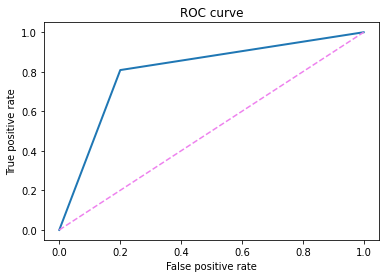

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test, y_pred_test))

## Logistic regression (BoW)

For C = 0.000010, val score is : 0.794647
For C = 0.000100, val score is : 0.797500
For C = 0.001000, val score is : 0.797535
For C = 0.010000, val score is : 0.798222
For C = 0.100000, val score is : 0.800992
For C = 1.000000, val score is : 0.808086
For C = 10.000000, val score is : 0.809676
For C = 100.000000, val score is : 0.800974


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


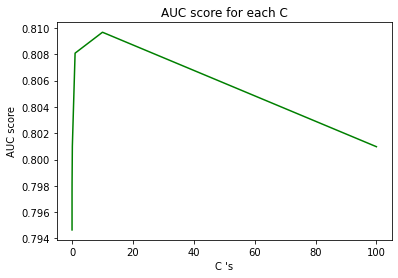


The optimal C is 10.000000.


In [ ]:
val_auc = []
Cs = [0.00001,0.0001,0.001,0.01,0.1,1,10,100]
for i in Cs:
    clf = LogisticRegression(C=i,class_weight='balanced')
    clf.fit(X_bow,np.array(y_train).reshape(-1,))
    y_pred_val = clf.predict(X_val_bow)
    score = roc_auc_score(y_val, y_pred_val)
    print('For C = %f, val score is : %f' %(i,score))
    val_auc.append(score)
    
#plot errors and val scores
fig, ax = plt.subplots()
ax.plot(Cs, val_auc,c='g')
plt.grid()
plt.title("AUC score for each C")
plt.xlabel("C 's")
plt.ylabel("AUC score")
plt.grid()
plt.show()

# determining best C
MSE = [x for x in val_auc]
# determining best C
optimal_c = Cs[MSE.index(max(MSE))]
print('\nThe optimal C is %f.' % optimal_c)

              precision    recall  f1-score   support

         0.0       0.78      0.82      0.80      4420
         1.0       0.85      0.82      0.84      5586

    accuracy                           0.82     10006
   macro avg       0.82      0.82      0.82     10006
weighted avg       0.82      0.82      0.82     10006

Various metrics of model:
Precision is: 82.20551378446115
Recall is: 84.97409326424871
F1 score is: 83.56687898089173
Accuracy is: 81.95082950229862 



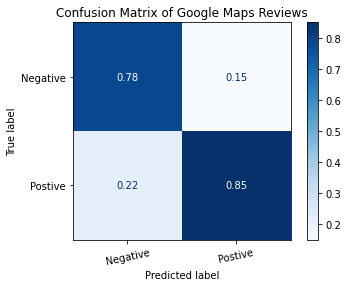

In [ ]:
#train model with C.
clf = LogisticRegression(C=optimal_c,class_weight='balanced')
clf.fit(X_bow,y_train)
#predict y labels with model on test data
predict = clf.predict(X_test_bow)
#Performance of the model on the test data
cal_metrics(predict,y_test)

In [ ]:
y_test.value_counts()

1.0    5404
0.0    4602
Name: Score, dtype: int64

In [ ]:
y_pred_train = clf.predict(X_bow)
y_pred_test = clf.predict(X_test_bow)
y_pred_val = clf.predict(X_val_bow)

train_score = accuracy_score(y_train, y_pred_train)
val_score = accuracy_score(y_val, y_pred_val)
test_score = accuracy_score(y_test, y_pred_test)
# report results
print('\nTraining accuracy score was:', train_score)
print('\nVal accuracy score was:', val_score)
print('\nTesting accuracy score was:', test_score)


Training accuracy score was: 0.9295083940068596

Val accuracy score was: 0.8093283156574296

Testing accuracy score was: 0.8195082950229862


In [ ]:
#Lets get some of the important features/words for both positive and negative classes
imp_features(bow,clf)

Top positive and negative features/words


,positive,negative
0,great,not
1,best,bad
2,delicious,normal
3,excellent,worst
4,love,average
5,amazing,but
6,wonderful,ok
7,nice,is
8,riyadh,overpriced
9,tasty,poor


ROC AUC score =  0.816873943070483


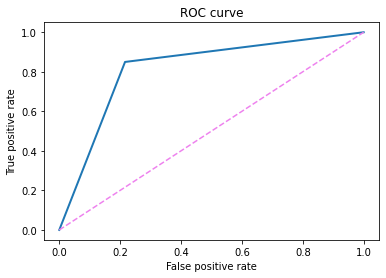

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test, y_pred_test))

## Naive Bayes (TD-IDF)

For Alpha = 0.000001, val score is : 0.742282
For Alpha = 0.000010, val score is : 0.742623
For Alpha = 0.000100, val score is : 0.742735
For Alpha = 0.001000, val score is : 0.742735
For Alpha = 0.010000, val score is : 0.744095
For Alpha = 0.100000, val score is : 0.748293
For Alpha = 1.000000, val score is : 0.758715
For Alpha = 10.000000, val score is : 0.777849
For Alpha = 100.000000, val score is : 0.791287
For Alpha = 1000.000000, val score is : 0.792988


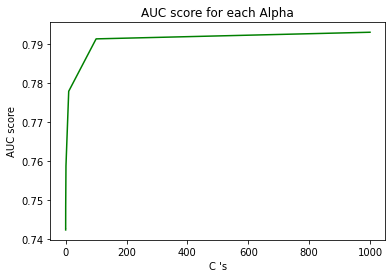


The optimal Alpha is 1000.000000.


In [ ]:
val_auc = []
Cs = [10**x for x in range(-6,4)]
for i in Cs:
    clf = MultinomialNB(alpha=i,fit_prior=None)
    clf.fit(X_tfidf,np.array(y_train).reshape(-1,))
    y_pred_val = clf.predict(X_val_tfidf)
    score = roc_auc_score(y_val, y_pred_val)
    print('For Alpha = %f, val score is : %f' %(i,score))
    val_auc.append(score)
    
#plot errors and val scores
fig, ax = plt.subplots()
ax.plot(Cs, val_auc,c='g')
plt.grid()
plt.title("AUC score for each Alpha")
plt.xlabel("C 's")
plt.ylabel("AUC score")
plt.grid()
plt.show()

# determining best alpha
MSE = [x for x in val_auc]
# determining best alpha
optimal_alpha = Cs[MSE.index(max(MSE))]
print('\nThe optimal Alpha is %f.' % optimal_alpha)

              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79      4709
         1.0       0.81      0.82      0.81      5297

    accuracy                           0.80     10006
   macro avg       0.80      0.80      0.80     10006
weighted avg       0.80      0.80      0.80     10006

Various metrics of model:
Precision is: 82.23522748725694
Recall is: 80.60695780903035
F1 score is: 81.41295206055509
Accuracy is: 80.12192684389366 



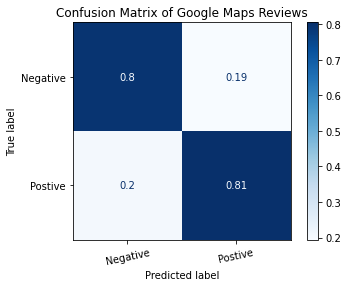

In [ ]:
#train model with C.
clf = MultinomialNB(alpha=optimal_alpha,fit_prior=None)
clf.fit(X_tfidf,y_train)
#predict y labels with model on test data
predict = clf.predict(X_test_tfidf)
#Performance of the model on the test data
cal_metrics(predict,y_test)

In [ ]:
y_pred_train = clf.predict(X_tfidf)
y_pred_test = clf.predict(X_test_tfidf)
y_pred_val = clf.predict(X_val_tfidf)

train_score = accuracy_score(y_train, y_pred_train)
val_score = accuracy_score(y_val, y_pred_val)
test_score = accuracy_score(y_test, y_pred_test)
# report results
print('\nTraining accuracy score was:', train_score)
print('\nVal accuracy score was:', val_score)
print('\nTesting accuracy score was:', test_score)


Training accuracy score was: 0.8862747457729105

Val accuracy score was: 0.793020868970236

Testing accuracy score was: 0.8012192684389366


In [ ]:
#Lets get some of the important features/words for both positive and negative classes
imp_features(tfidf_vect,clf)

Top positive and negative features/words


,positive,negative
0,and,00
1,great,00pm
2,food,04
3,good,05
4,the,09
5,best,105
6,delicious,10pm
7,love,10rating
8,service,10sar
9,is,11433


ROC AUC score =  0.8007966317222487


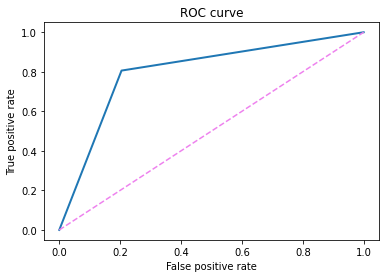

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test, y_pred_test))

## Naive Bayes (BoW)

For Alpha = 0.000001, val score is : 0.748802
For Alpha = 0.000010, val score is : 0.749365
For Alpha = 0.000100, val score is : 0.749593
For Alpha = 0.001000, val score is : 0.750384
For Alpha = 0.010000, val score is : 0.750947
For Alpha = 0.100000, val score is : 0.755486
For Alpha = 1.000000, val score is : 0.768074
For Alpha = 10.000000, val score is : 0.791080
For Alpha = 100.000000, val score is : 0.801923
For Alpha = 1000.000000, val score is : 0.803528


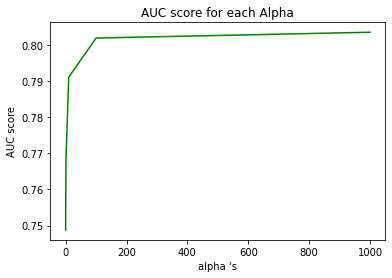


The optimal Alpha is 1000.000000.


In [ ]:
val_auc = []
Cs = [10**x for x in range(-6,4)]
for i in Cs:
    clf = MultinomialNB(alpha=i,fit_prior=None)
    clf.fit(X_bow,np.array(y_train).reshape(-1,))
    y_pred_val = clf.predict(X_val_bow)
    score = roc_auc_score(y_val, y_pred_val)
    print('For Alpha = %f, val score is : %f' %(i,score))
    val_auc.append(score)
    
#plot errors and val scores
fig, ax = plt.subplots()
ax.plot(Cs, val_auc,c='g')
plt.grid()
plt.title("AUC score for each Alpha")
plt.xlabel("alpha 's")
plt.ylabel("AUC score")
plt.grid()
plt.show()

# determining best alpha
MSE = [x for x in val_auc]
# determining best alpha
optimal_alpha = Cs[MSE.index(max(MSE))]
print('\nThe optimal Alpha is %f.' % optimal_alpha)

              precision    recall  f1-score   support

         0.0       0.80      0.79      0.80      4683
         1.0       0.82      0.83      0.82      5323

    accuracy                           0.81     10006
   macro avg       0.81      0.81      0.81     10006
weighted avg       0.81      0.81      0.81     10006

Various metrics of model:
Precision is: 83.07345481871126
Recall is: 81.82827535159142
F1 score is: 82.44616388552252
Accuracy is: 81.18129122526484 



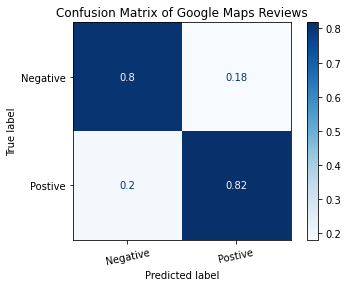

In [ ]:
#train model with C.
clf = MultinomialNB(alpha=optimal_alpha,fit_prior=None)
clf.fit(X_bow,y_train)
#predict y labels with model on test data
predict = clf.predict(X_test_bow)
#Performance of the model on the test data
cal_metrics(predict,y_test)

In [ ]:
y_pred_train = clf.predict(X_bow)
y_pred_test = clf.predict(X_test_bow)
y_pred_val = clf.predict(X_val_bow)

train_score = accuracy_score(y_train, y_pred_train)
val_score = accuracy_score(y_val, y_pred_val)
test_score = accuracy_score(y_test, y_pred_test)
# report results
print('\nTraining accuracy score was:', train_score)
print('\nVal accuracy score was:', val_score)
print('\nTesting accuracy score was:', test_score)


Training accuracy score was: 0.8827245923340754

Val accuracy score was: 0.8035123731326262

Testing accuracy score was: 0.8118129122526484


In [ ]:
#Lets get some of the important features/words for both positive and negative classes
imp_features(bow,clf)

Top positive and negative features/words


,positive,negative
0,great,00
1,and,00pm
2,food,04
3,good,05
4,delicious,09
5,best,105
6,the,10pm
7,love,10rating
8,service,10sar
9,is,11433


ROC AUC score =  0.8112491559843802


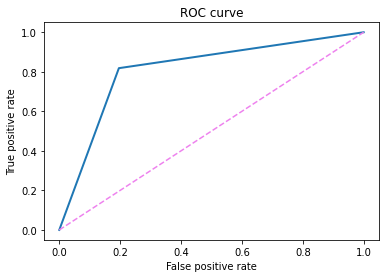

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test, y_pred_test))

## Decision Trees (TD-IDF)

For Alpha = 1.000000, val score is : 0.601440
For Alpha = 5.000000, val score is : 0.645740
For Alpha = 10.000000, val score is : 0.705640
For Alpha = 50.000000, val score is : 0.717988
For Alpha = 100.000000, val score is : 0.700994
For Alpha = 500.000000, val score is : 0.704328
For Alpha = 1000.000000, val score is : 0.700068


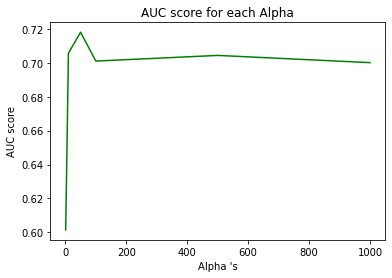


The optimal Alpha is 50.000000.


In [ ]:
val_auc = []
Cs = [1, 5, 10, 50, 100, 500, 1000]
for i in Cs:
    clf = DecisionTreeClassifier(max_depth=i)
    clf.fit(X_tfidf,np.array(y_train).reshape(-1,))
    y_pred_val = clf.predict(X_val_tfidf)
    score = roc_auc_score(y_val, y_pred_val)
    print('For Alpha = %f, val score is : %f' %(i,score))
    val_auc.append(score)
    
#plot errors and val scores
fig, ax = plt.subplots()
ax.plot(Cs, val_auc,c='g')
plt.grid()
plt.title("AUC score for each Alpha")
plt.xlabel("Alpha 's")
plt.ylabel("AUC score")
plt.grid()
plt.show()

# determining best alpha
MSE = [x for x in val_auc]
# determining best alpha
optimal_alpha = Cs[MSE.index(max(MSE))]
print('\nThe optimal Alpha is %f.' % optimal_alpha)

              precision    recall  f1-score   support

         0.0       0.74      0.68      0.71      4969
         1.0       0.71      0.76      0.73      5037

    accuracy                           0.72     10006
   macro avg       0.72      0.72      0.72     10006
weighted avg       0.72      0.72      0.72     10006

Various metrics of model:
Precision is: 76.05717689100655
Recall is: 70.89193190229459
F1 score is: 73.38377550043099
Accuracy is: 72.22666400159903 



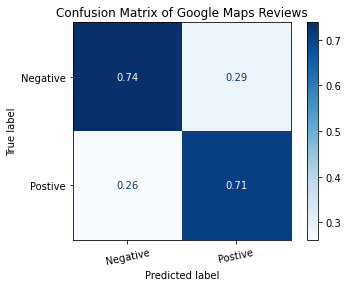

In [ ]:
#train model with C.
clf = DecisionTreeClassifier(max_depth=optimal_alpha)
clf.fit(X_tfidf,y_train)
#predict y labels with model on test data
predict = clf.predict(X_test_tfidf)
#Performance of the model on the test data
cal_metrics(predict,y_test)

In [ ]:
y_pred_train = clf.predict(X_tfidf)
y_pred_test = clf.predict(X_test_tfidf)
y_pred_val = clf.predict(X_val_tfidf)

train_score = accuracy_score(y_train, y_pred_train)
val_score = accuracy_score(y_val, y_pred_val)
test_score = accuracy_score(y_test, y_pred_test)
# report results
print('\nTraining accuracy score was:', train_score)
print('\nVal accuracy score was:', val_score)
print('\nTesting accuracy score was:', test_score)


Training accuracy score was: 0.9353150009025814

Val accuracy score was: 0.7078344166951762

Testing accuracy score was: 0.7222666400159904


ROC AUC score =  0.7234296725492826


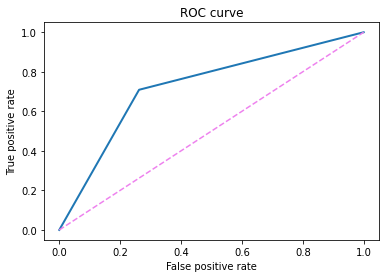

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test, y_pred_test))

## Decision Tree (BoW)

For Alpha = 1.000000, val score is : 0.601440
For Alpha = 5.000000, val score is : 0.646300
For Alpha = 10.000000, val score is : 0.704588
For Alpha = 50.000000, val score is : 0.748594
For Alpha = 100.000000, val score is : 0.736792
For Alpha = 500.000000, val score is : 0.741000
For Alpha = 1000.000000, val score is : 0.745271


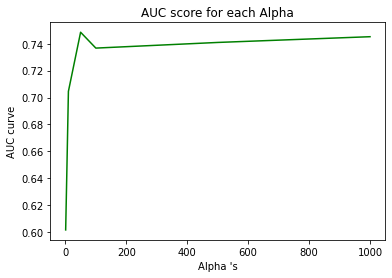


The optimal Alpha is 50.000000.


In [ ]:
val_auc = []
Cs = [1, 5, 10, 50, 100, 500, 1000]
for i in Cs:
    clf = DecisionTreeClassifier(max_depth=i)
    clf.fit(X_bow,np.array(y_train).reshape(-1,))
    y_pred_val = clf.predict(X_val_bow)
    score = roc_auc_score(y_val, y_pred_val)
    print('For Alpha = %f, val score is : %f' %(i,score))
    val_auc.append(score)
    
#plot errors and val scores
fig, ax = plt.subplots()
ax.plot(Cs, val_auc,c='g')
plt.grid()
plt.title("AUC score for each Alpha")
plt.xlabel("Alpha 's")
plt.ylabel("AUC curve")
plt.grid()
plt.show()

# determining best alpha
MSE = [x for x in val_auc]
# determining best alpha
optimal_alpha = Cs[MSE.index(max(MSE))]
print('\nThe optimal Alpha is %f.' % optimal_alpha)

              precision    recall  f1-score   support

         0.0       0.76      0.72      0.74      4808
         1.0       0.75      0.78      0.77      5198

    accuracy                           0.76     10006
   macro avg       0.76      0.75      0.76     10006
weighted avg       0.76      0.76      0.76     10006

Various metrics of model:
Precision is: 78.49172758753366
Recall is: 75.49962990377497
F1 score is: 76.96661007357102
Accuracy is: 75.59464321407155 



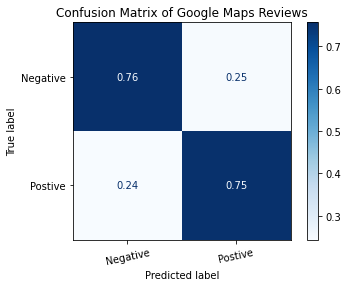

In [ ]:
#train model with C.
clf = DecisionTreeClassifier(max_depth=optimal_alpha)
clf.fit(X_bow,y_train)
#predict y labels with model on test data
predict = clf.predict(X_test_bow)
#Performance of the model on the test data
cal_metrics(predict,y_test)

In [ ]:
y_pred_train = clf.predict(X_bow)
y_pred_test = clf.predict(X_test_bow)
y_pred_val = clf.predict(X_val_bow)

train_score = accuracy_score(y_train, y_pred_train)
val_score = accuracy_score(y_val, y_pred_val)
test_score = accuracy_score(y_test, y_pred_test)
# report results
print('\nTraining accuracy score was:', train_score)
print('\nVal accuracy score was:', val_score)
print('\nTesting accuracy score was:', test_score)


Training accuracy score was: 0.9282447800710031

Val accuracy score was: 0.7444406431748204

Testing accuracy score was: 0.7559464321407156


ROC AUC score =  0.7560292229652027


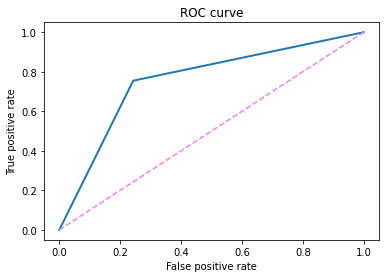

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test, y_pred_test))

## RandomForest (TD-IDF)

For Alpha = 5.000000, val score is : 0.732368
For Alpha = 10.000000, val score is : 0.767133
For Alpha = 50.000000, val score is : 0.810639
For Alpha = 100.000000, val score is : 0.812346
For Alpha = 120.000000, val score is : 0.815822


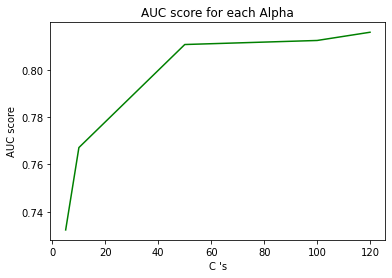


The optimal Alpha is 120.000000.


In [ ]:
val_auc = []
Cs = [5, 10, 50, 100, 120]
for i in Cs:
    clf = RandomForestClassifier(n_jobs= -1,class_weight='balanced',n_estimators=i)
    clf.fit(X_tfidf,np.array(y_train).reshape(-1,))
    y_pred_val = clf.predict(X_val_tfidf)
    score = roc_auc_score(y_val, y_pred_val)
    print('For Alpha = %f, val score is : %f' %(i,score))
    val_auc.append(score)
    
#plot errors and val scores
fig, ax = plt.subplots()
ax.plot(Cs, val_auc,c='g')
plt.grid()
plt.title("AUC score for each Alpha")
plt.xlabel("C 's")
plt.ylabel("AUC score")
plt.grid()
plt.show()

# determining best alpha
MSE = [x for x in val_auc]
# determining best alpha
optimal_alpha = Cs[MSE.index(max(MSE))]
print('\nThe optimal Alpha is %f.' % optimal_alpha)

              precision    recall  f1-score   support

         0.0       0.79      0.80      0.79      4528
         1.0       0.83      0.82      0.83      5478

    accuracy                           0.81     10006
   macro avg       0.81      0.81      0.81     10006
weighted avg       0.81      0.81      0.81     10006

Various metrics of model:
Precision is: 82.092004381161
Recall is: 83.21613619541081
F1 score is: 82.65024811615513
Accuracy is: 81.13132120727563 



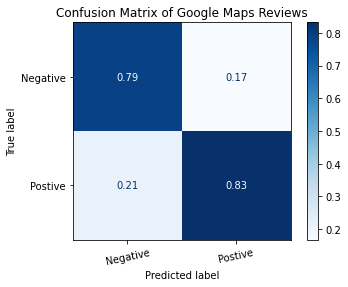

In [ ]:
#train model with C.
clf = RandomForestClassifier(n_jobs= -1,class_weight='balanced',n_estimators=optimal_alpha)
clf.fit(X_tfidf,y_train)
#predict y labels with model on test data
predict = clf.predict(X_test_tfidf)
#Performance of the model on the test data
cal_metrics(predict,y_test)

In [ ]:
y_pred_train = clf.predict(X_tfidf)
y_pred_test = clf.predict(X_test_tfidf)
y_pred_val = clf.predict(X_val_tfidf)

train_score = accuracy_score(y_train, y_pred_train)
val_score = accuracy_score(y_val, y_pred_val)
test_score = accuracy_score(y_test, y_pred_test)
# report results
print('\nTraining accuracy score was:', train_score)
print('\nVal accuracy score was:', val_score)
print('\nTesting accuracy score was:', test_score)


Training accuracy score was: 0.9998796558156328

Val accuracy score was: 0.8134336868514084

Testing accuracy score was: 0.8113132120727563


ROC AUC score =  0.8094965871048246


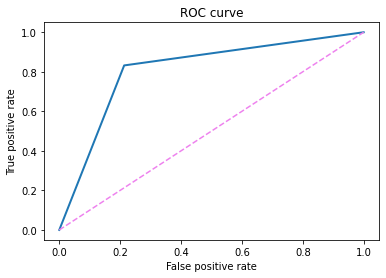

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test, y_pred_test))

## RandomForest (BoW)

For Alpha = 5.000000, val score is : 0.762087
For Alpha = 10.000000, val score is : 0.786006
For Alpha = 50.000000, val score is : 0.807875
For Alpha = 100.000000, val score is : 0.810965
For Alpha = 120.000000, val score is : 0.811443


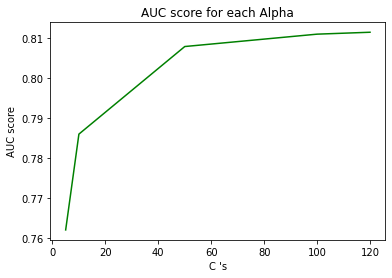


The optimal Alpha is 120.000000.


In [ ]:
val_auc = []
Cs = [5, 10, 50, 100, 120]
for i in Cs:
    clf = RandomForestClassifier(n_jobs= -1,class_weight='balanced',n_estimators=i)
    clf.fit(X_bow,np.array(y_train).reshape(-1,))
    y_pred_val = clf.predict(X_val_bow)
    score = roc_auc_score(y_val, y_pred_val)
    print('For Alpha = %f, val score is : %f' %(i,score))
    val_auc.append(score)
    
#plot errors and val scores
fig, ax = plt.subplots()
ax.plot(Cs, val_auc,c='g')
plt.grid()
plt.title("AUC score for each Alpha")
plt.xlabel("C 's")
plt.ylabel("AUC score")
plt.grid()
plt.show()

# determining best alpha
MSE = [x for x in val_auc]
# determining best alpha
optimal_alpha = Cs[MSE.index(max(MSE))]
print('\nThe optimal Alpha is %f.' % optimal_alpha)

              precision    recall  f1-score   support

         0.0       0.78      0.81      0.80      4418
         1.0       0.85      0.82      0.83      5588

    accuracy                           0.82     10006
   macro avg       0.82      0.82      0.82     10006
weighted avg       0.82      0.82      0.82     10006

Various metrics of model:
Precision is: 82.03292770221904
Recall is: 84.8260547742413
F1 score is: 83.4061135371179
Accuracy is: 81.77093743753747 



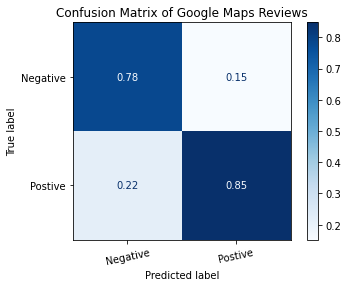

In [ ]:
#train model with C.
clf = RandomForestClassifier(n_jobs= -1,class_weight='balanced',n_estimators=optimal_alpha)
clf.fit(X_bow,y_train)
#predict y labels with model on test data
predict = clf.predict(X_test_bow)
#Performance of the model on the test data
cal_metrics(predict,y_test)

In [ ]:
y_pred_train = clf.predict(X_bow)
y_pred_test = clf.predict(X_test_bow)
y_pred_val = clf.predict(X_val_bow)

train_score = accuracy_score(y_train, y_pred_train)
val_score = accuracy_score(y_val, y_pred_val)
test_score = accuracy_score(y_test, y_pred_test)
# report results
print('\nTraining accuracy score was:', train_score)
print('\nVal accuracy score was:', val_score)
print('\nTesting accuracy score was:', test_score)


Training accuracy score was: 0.9998796558156328

Val accuracy score was: 0.8138898392062949

Testing accuracy score was: 0.8177093743753747


ROC AUC score =  0.8150472664831144


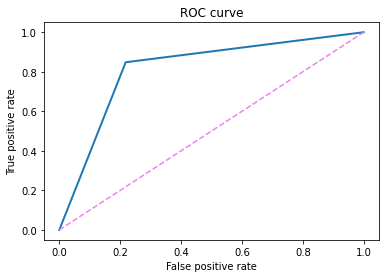

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test, y_pred_test))

## XGBoost (TD-IDF)

In [ ]:
from xgboost import XGBClassifier

For Alpha = 5.000000, val score is : 0.662410
For Alpha = 10.000000, val score is : 0.678660
For Alpha = 50.000000, val score is : 0.745176
For Alpha = 100.000000, val score is : 0.769119
For Alpha = 120.000000, val score is : 0.771481
For Alpha = 200.000000, val score is : 0.786259
For Alpha = 400.000000, val score is : 0.799527


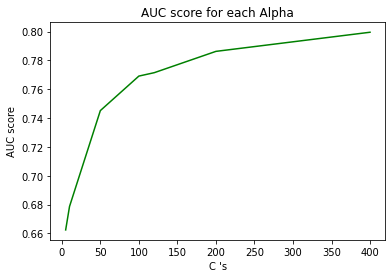


The optimal Alpha is 400.000000.


In [ ]:
val_auc = []
Cs = [5, 10, 50, 100, 120,200,400]
for i in Cs:
    clf = XGBClassifier(n_jobs= -1,class_weight='balanced',n_estimators=i)
    clf.fit(X_tfidf,np.array(y_train).reshape(-1,))
    y_pred_val = clf.predict(X_val_tfidf)
    score = roc_auc_score(y_val, y_pred_val)
    print('For Alpha = %f, val score is : %f' %(i,score))
    val_auc.append(score)
    
#plot errors and val scores
fig, ax = plt.subplots()
ax.plot(Cs, val_auc,c='g')
plt.grid()
plt.title("AUC score for each Alpha")
plt.xlabel("C 's")
plt.ylabel("AUC score")
plt.grid()
plt.show()

# determining best alpha
MSE = [x for x in val_auc]
# determining best alpha
optimal_alpha = Cs[MSE.index(max(MSE))]
print('\nThe optimal Alpha is %f.' % optimal_alpha)

              precision    recall  f1-score   support

         0.0       0.74      0.82      0.78      4166
         1.0       0.86      0.79      0.82      5840

    accuracy                           0.80     10006
   macro avg       0.80      0.80      0.80     10006
weighted avg       0.81      0.80      0.80     10006

Various metrics of model:
Precision is: 79.40068493150685
Recall is: 85.80680977054034
F1 score is: 82.47954464603345
Accuracy is: 80.31181291225265 



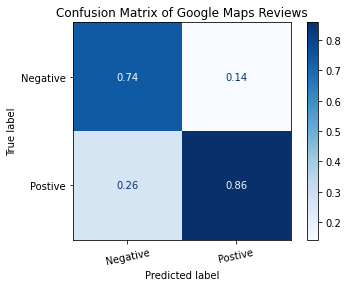

In [ ]:
#train model with C.
clf = XGBClassifier(n_jobs= -1,class_weight='balanced',n_estimators=optimal_alpha)
clf.fit(X_tfidf,y_train)
#predict y labels with model on test data
predict = clf.predict(X_test_tfidf)
#Performance of the model on the test data
cal_metrics(predict,y_test)

In [ ]:
y_pred_train = clf.predict(X_tfidf)
y_pred_test = clf.predict(X_test_tfidf)
y_pred_val = clf.predict(X_val_tfidf)

train_score = accuracy_score(y_train, y_pred_train)
val_score = accuracy_score(y_val, y_pred_val)
test_score = accuracy_score(y_test, y_pred_test)
# report results
print('\nTraining accuracy score was:', train_score)
print('\nVal accuracy score was:', val_score)
print('\nTesting accuracy score was:', test_score)


Training accuracy score was: 0.8411757626812685

Val accuracy score was: 0.7988368114950394

Testing accuracy score was: 0.8031181291225264


ROC AUC score =  0.7983300071317109


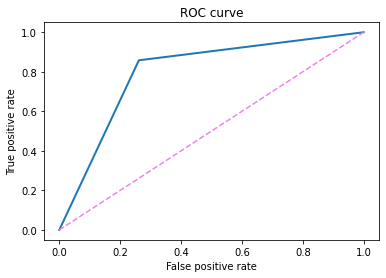

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test, y_pred_test))

## XGBoost (BoW)

For Alpha = 5.000000, val score is : 0.646439
For Alpha = 10.000000, val score is : 0.684191
For Alpha = 50.000000, val score is : 0.746092
For Alpha = 100.000000, val score is : 0.775226
For Alpha = 120.000000, val score is : 0.779714
For Alpha = 200.000000, val score is : 0.784736
For Alpha = 400.000000, val score is : 0.797121


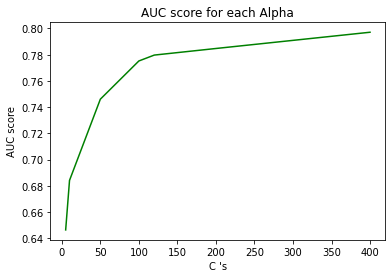


The optimal Alpha is 400.000000.


In [ ]:
val_auc = []
Cs = [5, 10, 50, 100, 120,200,400]
for i in Cs:
    clf = XGBClassifier(n_jobs= -1,class_weight='balanced',n_estimators=i)
    clf.fit(X_bow,np.array(y_train).reshape(-1,))
    y_pred_val = clf.predict(X_val_bow)
    score = roc_auc_score(y_val, y_pred_val)
    print('For Alpha = %f, val score is : %f' %(i,score))
    val_auc.append(score)
    
#plot errors and val scores
fig, ax = plt.subplots()
ax.plot(Cs, val_auc,c='g')
plt.grid()
plt.title("AUC score for each Alpha")
plt.xlabel("C 's")
plt.ylabel("AUC score")
plt.grid()
plt.show()

# determining best alpha
MSE = [x for x in val_auc]
# determining best alpha
optimal_alpha = Cs[MSE.index(max(MSE))]
print('\nThe optimal Alpha is %f.' % optimal_alpha)

              precision    recall  f1-score   support

         0.0       0.74      0.82      0.78      4117
         1.0       0.87      0.79      0.83      5889

    accuracy                           0.81     10006
   macro avg       0.80      0.81      0.80     10006
weighted avg       0.81      0.81      0.81     10006

Various metrics of model:
Precision is: 79.38529461708269
Recall is: 86.5099925980755
F1 score is: 82.79465155406004
Accuracy is: 80.58165100939436 



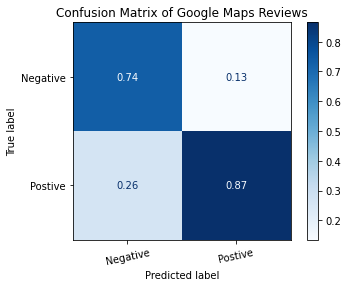

In [ ]:
#train model with C.
clf = clf = XGBClassifier(n_jobs= -1,class_weight='balanced',n_estimators=optimal_alpha)
clf.fit(X_bow,y_train)
#predict y labels with model on test data
predict = clf.predict(X_test_bow)
#Performance of the model on the test data
cal_metrics(predict,y_test)

In [ ]:
y_pred_train = clf.predict(X_bow)
y_pred_test = clf.predict(X_test_bow)
y_pred_val = clf.predict(X_val_bow)

train_score = accuracy_score(y_train, y_pred_train)
val_score = accuracy_score(y_val, y_pred_val)
test_score = accuracy_score(y_test, y_pred_test)
# report results
print('\nTraining accuracy score was:', train_score)
print('\nVal accuracy score was:', val_score)
print('\nTesting accuracy score was:', test_score)


Training accuracy score was: 0.8339250255731392

Val accuracy score was: 0.7964420116318851

Testing accuracy score was: 0.8058165100939436


ROC AUC score =  0.8006507887183218


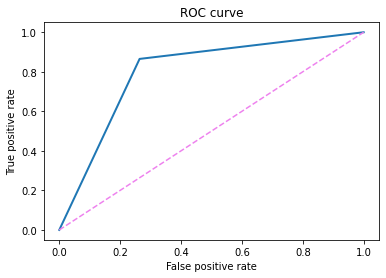

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test, y_pred_test))

## Long short term memory

In [81]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout

In [82]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words= 50000)
tokenizer.fit_on_texts(X_train)

In [83]:
X_train_tok = tokenizer.texts_to_sequences(X_train)
X_test_tok = tokenizer.texts_to_sequences(X_test)
X_val_tok = tokenizer.texts_to_sequences(X_val)

In [84]:
max_review_length = 600
X_train_pad = sequence.pad_sequences(X_train_tok, maxlen=max_review_length)
X_test_pad = sequence.pad_sequences(X_test_tok, maxlen=max_review_length)
X_val_pad = sequence.pad_sequences(X_val_tok, maxlen=max_review_length)

In [85]:
embedding_vector_length = 55
top_words = 5000
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model.add(LSTM(256,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 600, 55)           275000    
_________________________________________________________________
lstm (LSTM)                  (None, 600, 256)          319488    
_________________________________________________________________
dropout (Dropout)            (None, 600, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 791,737
Trainable params: 791,737
Non-trainable params: 0
_________________________________________________________________
None


In [86]:
history = model.fit(X_train_pad, y_train, epochs=3, batch_size=64,validation_data=(X_val_pad,y_val))
# Final evaluation of the model on test data
scores = model.evaluate(X_test_pad, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/3
514/514 [==============================] - 59s 103ms/step - loss: 0.4233 - accuracy: 0.8060 - val_loss: 0.4394 - val_accuracy: 0.7883
Epoch 2/3
514/514 [==============================] - 52s 102ms/step - loss: 0.3278 - accuracy: 0.8629 - val_loss: 0.3877 - val_accuracy: 0.8258
Epoch 3/3
514/514 [==============================] - 52s 102ms/step - loss: 0.2876 - accuracy: 0.8817 - val_loss: 0.3874 - val_accuracy: 0.8227
Accuracy: 83.20%


Learning Curves: 


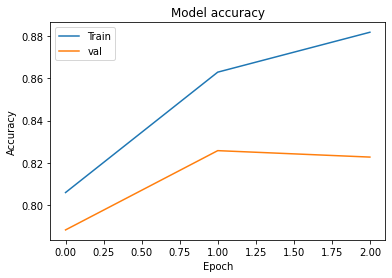

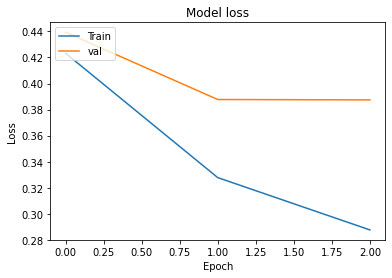

In [87]:
print('Learning Curves: ')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()
plt.close()

In [88]:
train_score = model.evaluate(X_train_pad, y_train, verbose=0)
val_score = model.evaluate(X_val_pad, y_val, verbose=0)
test_score = model.evaluate(X_test_pad, y_test, verbose=0)
# report results
print('\nTraining accuracy score was:', train_score[1])
print('\nVal accuracy score was:', val_score[1])
print('\nTesting accuracy score was:', test_score[1])


Training accuracy score was: 0.9111598134040833

Val accuracy score was: 0.8227373957633972

Testing accuracy score was: 0.8320086002349854


ROC AUC score =  0.9125430676173959


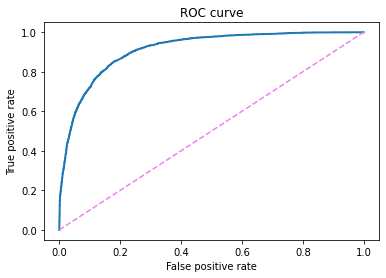

In [89]:
fpr, tpr, thresholds = roc_curve(y_test,model.predict(X_test_pad))
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test, model.predict(X_test_pad)))

In [90]:
y_pred_ltsm = model.predict(X_test_pad)
y_pred_ltsm = np.where(y_pred_ltsm<.53,0,1)

In [91]:
accuracy_score(y_pred_ltsm, y_test)

0.8306689291774583

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      5937
           1       0.80      0.84      0.82      5260

    accuracy                           0.83     11197
   macro avg       0.83      0.83      0.83     11197
weighted avg       0.83      0.83      0.83     11197

Various metrics of model:
Precision is: 84.46768060836501
Recall is: 80.4599782687432
F1 score is: 82.41513633834168
Accuracy is: 83.06689291774583 



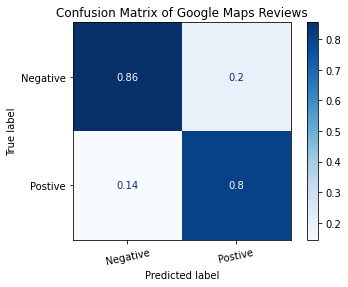

In [92]:
#Performance of the model on the test data
cal_metrics(y_pred_ltsm,y_test)

Save model:

In [95]:
from tensorflow.keras.models import save_model, load_model
import pickle
save_model(model,'/content/gdrive/MyDrive/Food/model_best.model')
with open('/content/gdrive/MyDrive/Food/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Food/model_best.model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Food/model_best.model/assets


## Bert

In [ ]:
!pip install bert-tensorflow
!pip install tqdm
!pip install tensorflow_hub

     |████████████████████████████████| 64 kB 2.4 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model

max_seq_length = 55
tf.keras.backend.clear_session()
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
                # ids of words
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
                # masking of ids
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
                # segment of ids
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

In [ ]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 55)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 55)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 55)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 7.4 MB/s 


In [ ]:
import tokenization
def bert_preprocess(sentence,tokenizer,max_seq_len=512):
    tokens=[]
    masks=[]
    segments=[]
    for word in sentence:
        word=tokenizer.tokenize(word)
        word=word[:max_seq_len-2]
        seq=["[CLS]"] + word + ["[SEP]"]
        token = tokenizer.convert_tokens_to_ids(seq)
        padding_tokens=token+[0]*(max_seq_len-len(token))
        mask=[1]*len(seq)
        masking=mask+[0]*(max_seq_len-len(token))
        segment=np.zeros(max_seq_length)
        
        tokens.append(padding_tokens)
        masks.append(masking)
        segments.append(segment)
    return np.array(tokens),np.array(masks),np.array(segments)

In [ ]:
tokenizer = tokenization.FullTokenizer(vocab_file,do_lower_case)

In [ ]:
bert_model.input

[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'segment_ids')>]

In [ ]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [ ]:
#Preprocessing for bert model
X_train_tokens, X_train_mask, X_train_segment=bert_preprocess(X_train.values,tokenizer,55)
X_test_tokens, X_test_mask, X_test_segment=bert_preprocess(X_test.values,tokenizer,55)
X_val_tokens, X_val_mask, X_val_segment=bert_preprocess(X_val.values,tokenizer,55)

X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])
X_val_pooled_output=bert_model.predict([X_val_tokens, X_val_mask, X_val_segment])

In [ ]:
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model

In [ ]:
import datetime
from sklearn.metrics import roc_auc_score
auc=[]
val_auc=[]
BestAUC = 0
class LossHistory(tf.keras.callbacks.Callback):
    BestAUC = 0
    def on_train_begin(self, logs={}):
        self.history={'val_accuracy': []}


    def on_epoch_end(self, epoch, logs={}):
        global BestAUC
        ## on end of each epoch, we will get logs and update the self.history dict
        if logs.get('val_accuracy', -1) != -1:
            self.history['val_accuracy'].append(logs.get('val_accuracy'))
        auc_tr=(roc_auc_score(y_train,(self.model.predict(X_train_pooled_output))) )
        auc_val=(roc_auc_score (y_val, (self.model.predict(X_val_pooled_output) ) ) )
        print('\n  train_auc : ',auc_tr)
        print('  val_auc : ',auc_val)
        if (BestAUC < auc_val):
          BestAUC = auc_val
          print('Best score: ', BestAUC)
        auc.append(auc_tr)
        val_auc.append(auc_val)
        loss=logs.get('loss')

In [ ]:
#Callbacks
filepath="model1_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_loss',  verbose=1, save_best_only=True, mode='auto')

history_own = LossHistory()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=2, verbose=1)

In [ ]:
##create an NN and 
input = Input(shape=[768,],name='input_layer')
dense1=Dense(400, activation='relu',name='dense_1')(input)
dense2=Dense(220, activation='relu',name='dense_2')(dense1)
dense3=Dense(40, activation='relu',name='dense_3')(dense2)
output=Dense(1, activation='sigmoid',name='dense_4')(dense3)
model1 = Model(inputs=input, outputs=output)

In [ ]:
opt= tf.keras.optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer=opt,loss=tf.keras.losses.BinaryCrossentropy(),metrics='accuracy')

In [ ]:
tf.keras.backend.clear_session()
history = model1.fit(X_train_pooled_output,y_train,validation_data=(X_val_pooled_output,y_val),epochs=15,callbacks=[history_own])

Epoch 1/15
1039/1039 [==============================] - 3s 3ms/step - loss: 0.5344 - accuracy: 0.7338 - val_loss: 0.4959 - val_accuracy: 0.7714

  train_auc :  0.8603617432843659
  val_auc :  0.855471808234561
Best score:  0.855471808234561
Epoch 2/15
1039/1039 [==============================] - 3s 2ms/step - loss: 0.4818 - accuracy: 0.7768 - val_loss: 0.5158 - val_accuracy: 0.7660

  train_auc :  0.8714810028025712
  val_auc :  0.8646978759509043
Best score:  0.8646978759509043
Epoch 3/15
1039/1039 [==============================] - 3s 2ms/step - loss: 0.4683 - accuracy: 0.7846 - val_loss: 0.4649 - val_accuracy: 0.7822

  train_auc :  0.8777977893425613
  val_auc :  0.8633581188313735
Epoch 4/15
1039/1039 [==============================] - 3s 2ms/step - loss: 0.4622 - accuracy: 0.7877 - val_loss: 0.4757 - val_accuracy: 0.7807

  train_auc :  0.87705379616447
  val_auc :  0.8566541304954963
Epoch 5/15
1039/1039 [==============================] - 3s 2ms/step - loss: 0.4586 - accuracy: 0

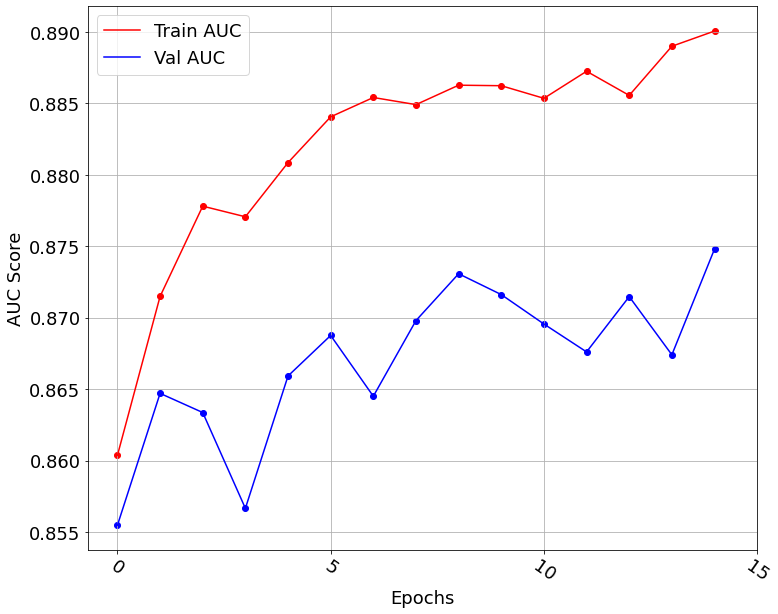

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12,10))
plt.plot(np.arange(len(auc)),auc,color="red")
plt.plot(np.arange(len(auc)),val_auc,color='blue')
plt.scatter(np.arange(len(auc)),auc,color='red')
plt.scatter(np.arange(len(auc)),val_auc,color='blue')
plt.xticks(np.arange(0,len(auc)+1,5),rotation=-35)
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend(['Train AUC','Val AUC'])
plt.grid()
plt.show()

Learning Curves: 


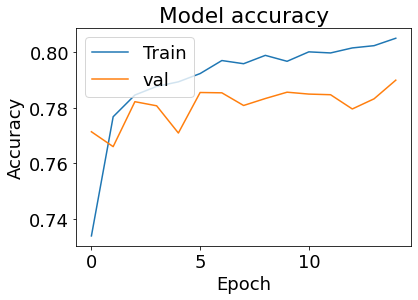

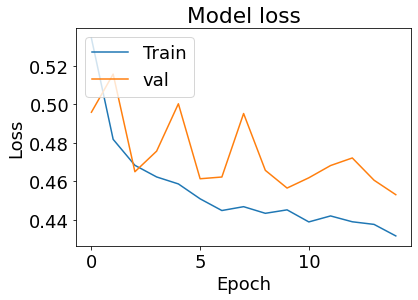

In [ ]:
print('Learning Curves: ')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()
plt.close()

In [ ]:
train_score = model1.evaluate(X_train_pooled_output, y_train, verbose=0)
val_score = model1.evaluate(X_val_pooled_output, y_val, verbose=0)
test_score = model1.evaluate(X_test_pooled_output, y_test, verbose=0)
# report results
print('\nTraining accuracy score was:', train_score[1])
print('\nVal accuracy score was:', val_score[1])
print('\nTesting accuracy score was:', test_score[1])


Training accuracy score was: 0.8116011619567871

Val accuracy score was: 0.7899418473243713

Testing accuracy score was: 0.7991205453872681


ROC AUC score =  0.8820804828203616


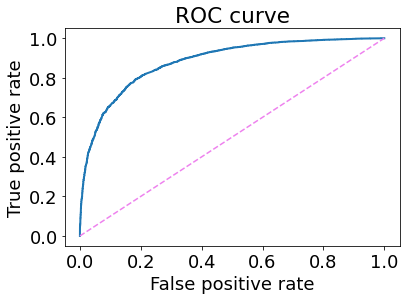

In [ ]:
y_pred = model1.predict(X_test_pooled_output)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.81      0.77      4226
           1       0.85      0.79      0.82      5780

    accuracy                           0.80     10006
   macro avg       0.79      0.80      0.80     10006
weighted avg       0.80      0.80      0.80     10006

Various metrics of model:
Precision is: 79.3598615916955
Recall is: 84.88156920799408
F1 score is: 82.02789699570815
Accuracy is: 79.912052768339 



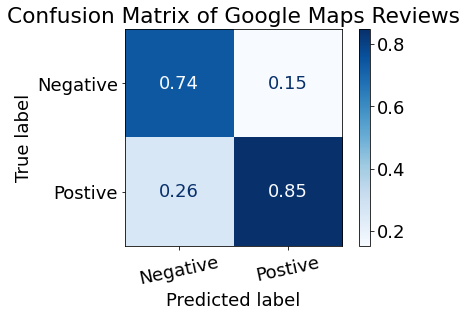

In [ ]:
#Performance of the model on the test data
y_pred = np.where(y_pred<.50,0,1)
cal_metrics(y_pred,y_test)

# Testing reviews

In [ ]:
from googletrans import Translator
translator = Translator(service_urls=[
      'translate.google.com.sa',
    ])

In [ ]:
text = "No parking"

text = pd.Series(text).apply(decontracted).apply(rem_num).apply(rem_stopwords).apply(rem_html)[0]
translator = Translator()
text = translator.translate(text, dest='en').text
X_text_tokens, X_text_mask, X_text_segment=bert_preprocess([text],tokenizer,55)
X_text_pooled_output=bert_model.predict([X_text_tokens, X_text_mask, X_text_segment])

y_pred = model1.predict(X_text_pooled_output)
result = ['ايجابي' if(y_pred  >= 0.50) else 'سلبي']
print('التقيم:', result[0])

التقيم: سلبي


In [ ]:
text = """
ابدا ما انصح فيه الشورما ليست لذيذه
"""
text = translator.translate(text, dest='en').text
tex= BOW.transform([text])
y_pred = model.predict(tex)
result = ['ايجابي' if(y_pred  == 1) else 'سلبي']
print('التقيم:', result[0])

التقيم: سلبي


# Flask

In [98]:
!pip install flask-ngrok
!pip install deep-translator
from deep_translator import GoogleTranslator, PonsTranslator, LingueeTranslator

     |████████████████████████████████| 97 kB 5.0 MB/s 
     |████████████████████████████████| 97 kB 7.8 MB/s 
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.0.1 which is incompatible.


In [97]:
import sqlite3
conn = sqlite3.connect('test.db', check_same_thread=False)
c = conn.cursor()

c.execute('''
          CREATE TABLE reviews
          ([review] TEXT, [score] TEXT)
          ''')
conn.commit()

In [96]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer

model = load_model('/content/gdrive/MyDrive/Food/model_best.model', compile=False)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

with open('/content/gdrive/MyDrive/Food/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
from flask import Flask,request,render_template
from flask_ngrok import run_with_ngrok
static_folder='/content/gdrive/MyDrive/Food/static/'
template_dir= '/content/gdrive/MyDrive/Food/templates/'
app = Flask(__name__,template_folder=template_dir,static_folder =static_folder )
run_with_ngrok(app)   
@app.route('/')

def home():
	return render_template('index.html')

@app.route('/',methods =['GET','POST'])
def predict():
	if request.method == 'POST':
		text = request.form['message']
		if (not text.isascii()):
				translator = Translator()
				text = GoogleTranslator(source='auto', target='en').translate(text=text)

		text1 = pd.Series(text).apply(decontracted).apply(rem_num).apply(rem_stopwords).apply(rem_html)[0]
		# X_text_tokens, X_text_mask, X_text_segment=bert_preprocess([text1],tokenizer,55)
		# X_text_pooled_output=bert_model.predict([X_text_tokens, X_text_mask, X_text_segment])
		# #convert test text to Bow vectors
		# X_text_bow = bow.transform([text1])
		# #don't forgot to normalize cv data
		# X_text_bow = normalize(X_text_bow,axis=0)
		# y_pred = model1.predict(X_text_pooled_output)
		X_text_tok = tokenizer.texts_to_sequences([text1])
		X_text_pad = sequence.pad_sequences(X_text_tok, maxlen=600)
		y_pred = model.predict(X_text_pad)
		y_pred = ['postive' if(y_pred  >= 0.50) else 'negative'][0]
		parms = (text,y_pred)
		c.execute("""
							INSERT INTO reviews (review, score)
										VALUES
										(?,?)
							""",parms)

		return render_template('result.html', prediction=y_pred)
@app.route('/admin')
def admin():  
	c.execute('''
						SELECT *
						FROM reviews
						''')

	conn.commit()
	rev_df = pd.DataFrame(c.fetchall(),columns=["Review","Rate"])
	postive = rev_df[rev_df.Rate == 'postive']
	negative = rev_df[rev_df.Rate == 'negative']
	if(len(negative)>0):
		plot_wordcloud(pd.DataFrame(negative.Review.apply(decontracted).apply(rem_num).apply(rem_stopwords).apply(rem_html).values), title="Word Cloud of Reviews", pn='n',max_words=5)
	if(len(postive)>0):
		plot_wordcloud(pd.DataFrame(postive.Review.apply(decontracted).apply(rem_num).apply(rem_stopwords).apply(rem_html).values), title="Word Cloud of Reviews", pn='p',max_words=5)

	return render_template('admin.html', tables=[rev_df.to_html(classes='data',index=False)], titles=['Reviews with prediction:'])

app.run()